In [755]:
#import sys
#sys.path.append("/Users/CC/anaconda/lib/python2.7/site-packages")

import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split as sk_split
from sklearn.cross_validation import KFold

from sklearn.decomposition import PCA
from sklearn import preprocessing

# for classfication algorithms
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF

import datetime
import time
%matplotlib inline

# CS109a Project: Hot Hand Theory

### by Zainab Doctor, Hubert Huang, Bailey Liao, Zecai Liang
------------------------------------------------------------------------

# Outline

## Part 1 - Cleaning Data
### 1.1 Select Relevant Features
### 1.2 Filter on [shot_clock] and [game_clock]
### 1.3 Filter on Length of Shot Series
//

## Part 2 - Examing Data 
### 2.1 Generate Make_Streak and Miss_Streak
### 2.2 Analysis of Top 5 Players
//

## Part 3 - Prediction Model
### 3.1 Logistic Regression
### 3.2 LDA & QDA
### 3.3 KNN
### 3.4 SVM
### 3.5 Random Forest
//

## Part 4 - Conditional Probability
### 4.1 Conditional Probability on Null Model
### 4.2 Conditional Probability considering Shot Difficulty
//

## Part 5 - Predictions on Long Streaks
### 5.1 Prediction vs Reality on the Last Shot of Streak
### 5.2 Prediction vs Reality on the Whole Streak

## Part 1 - Cleaning Data
by Zainab Doctor

In [2]:
#Read in data
shots = pd.read_csv('shot_logs.csv', delimiter=',')

print 'dimensions of dataset:', shots.shape
shots.head(3)


dimensions of dataset: (128069, 21)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148


### 1.1 Select Relevant Features

In [3]:
data = shots[['GAME_ID', 'LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 
              'SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'player_id']]

print data.shape

(128069, 13)


### 1.2 Filter on [shot_clock] and [game_clock]

In [4]:
data = data[data['SHOT_CLOCK'].notnull()]
#lose 5567 entries

data = data[data['SHOT_CLOCK'] > 1] #results in loss of 1004 shots taken with <1 second on the shot clock

#data = data[data['GAME_CLOCK'] != '0:00'] filtering based on GAME_CLOCK doesn't result in any further loss of entries

#Convert game clock to seconds
T = data['GAME_CLOCK'].values
gameclock_seconds = []

for i in range(T.shape[0]):
    x = T[i].split(':')
    gameclock_seconds.append(60*int(x[0]) + int(x[1]))

data['GAME_CLOCK'] = gameclock_seconds

data = data[data['GAME_CLOCK'] > 1] # results in loss of 2 entries



### * Plots for Posters
Distribution of selected features:
['SHOT_DIST'], ['CLOSE_DEF_DIST'], ['GAME_CLOCK']


by Zecai

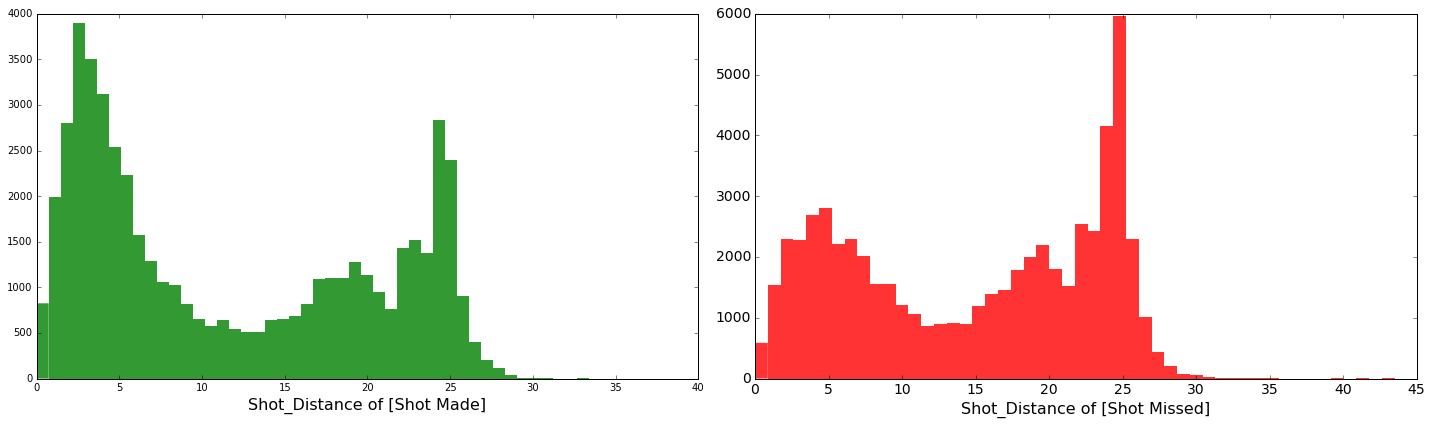

In [392]:
#Plot1: shot distances based on whether they were made or missed
subset1 = data[data['SHOT_RESULT'] == 'made']
subset2 = data[data['SHOT_RESULT'] == 'missed']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(subset1['SHOT_DIST'],50, color='green', alpha=0.8, edgecolor='none')
#ax1.set_title('Distribution of made shot distances ')
ax1.set_xlabel('Shot_Distance of [Shot Made]', fontsize=16)

ax2.hist(subset2['SHOT_DIST'],50, color='red', alpha=0.8, edgecolor='none')
ax2.set_xlabel('Shot_Distance of [Shot Missed]', fontsize=16)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.tight_layout()    
plt.show()

/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


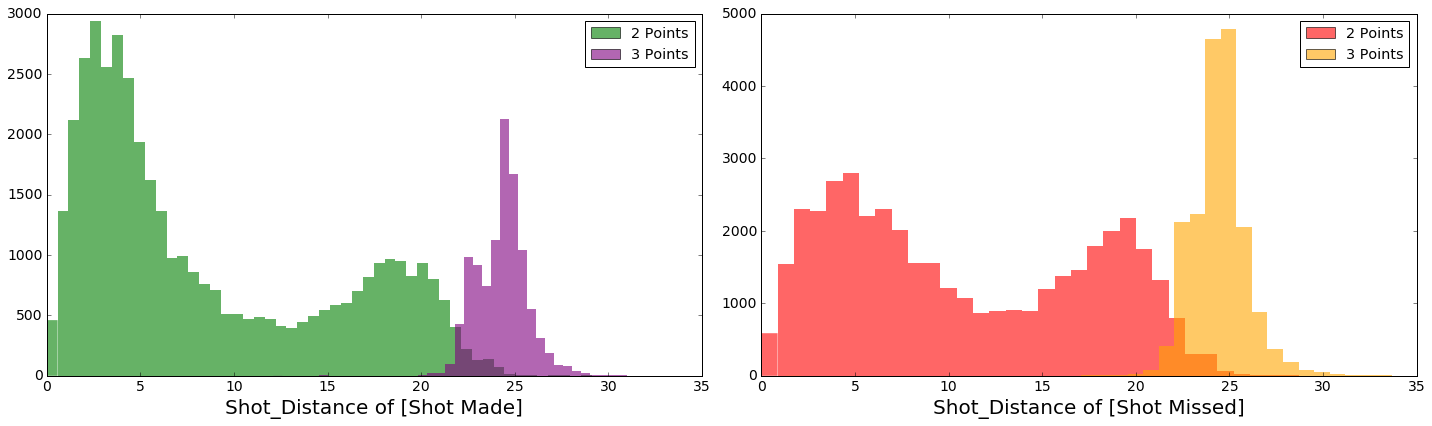

In [400]:
## Plot2: distribution of shot distance on shots made/missed, differentiating 2/3 points
subset3 = data[ (shots['PTS_TYPE'] == 2) & (data['SHOT_RESULT'] == 'made')]
subset4 = data[ (shots['PTS_TYPE'] == 3) & (data['SHOT_RESULT'] == 'made')]

subset5 = data[ (shots['PTS_TYPE'] == 2) & (data['SHOT_RESULT'] == 'missed')]
subset6 = data[ (shots['PTS_TYPE'] == 3) & (data['SHOT_RESULT'] == 'missed')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(subset3['SHOT_DIST'],50, color='green', alpha=0.6, edgecolor='none', label='2 Points')
ax1.hist(subset4['SHOT_DIST'],50, color='purple', alpha=0.6, edgecolor='none', label='3 Points')
#ax1.set_title('Distribution of made shot distances ')
ax1.set_xlabel('Shot_Distance of [Shot Made]', fontsize=20)
ax1.legend(fontsize = 'x-large')
ax1.set_xlim([0,35])

ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax2.hist(subset5['SHOT_DIST'],50, color='red', alpha=0.6, edgecolor='none', label='2 Points')
ax2.hist(subset6['SHOT_DIST'],50, color='orange', alpha=0.6, edgecolor='none', label='3 Points')
ax2.set_xlabel('Shot_Distance of [Shot Missed]', fontsize=20)
ax2.legend(fontsize = 'x-large')

ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlim([0,35])

plt.tight_layout()    
plt.show()

fig.savefig('shot_distance.png', bbox_inches='tight')

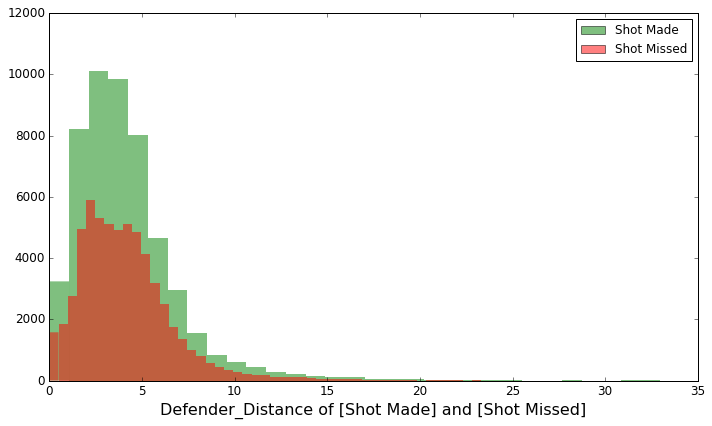

In [403]:
## Plot3: distribution of defenser_distance on shots made/missed

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(subset1['CLOSE_DEF_DIST'],50, color='green', alpha=0.5, edgecolor='none', label='Shot Made')
#ax1.set_title('Distribution of made shot distances ')
ax.hist(subset2['CLOSE_DEF_DIST'],50, color='red', alpha=0.5, edgecolor='none', label='Shot Missed')
ax.set_xlabel('Defender_Distance of [Shot Made] and [Shot Missed]', fontsize=16)
ax.legend(fontsize = 'large')
ax.set_xlim([0,35])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()    
plt.show()

#fig.savefig('defender_distance.png', bbox_inches='tight')

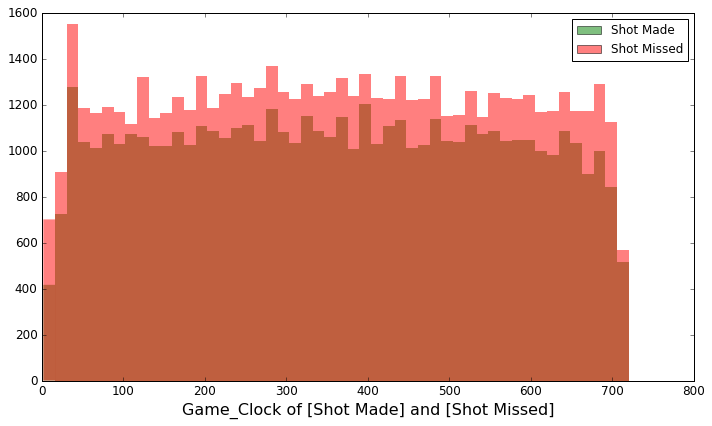

In [408]:
## Plot: distribution of game_clock on shots made/missed

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(subset1['GAME_CLOCK'],50, color='green', alpha=0.5, edgecolor='none', label='Shot Made')
#ax1.set_title('Distribution of made shot distances ')
ax.hist(subset2['GAME_CLOCK'],50, color='red', alpha=0.5, edgecolor='none', label='Shot Missed')
ax.set_xlabel('Game_Clock of [Shot Made] and [Shot Missed]', fontsize=16)
ax.legend(fontsize = 'large')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()    
plt.show()

#fig.savefig('defender_distance.png', bbox_inches='tight')

### 1.3 Filtering Data Based on Shots Taken by Players
- Filter out all the shot series shorter than 4

by Hubert Huang

number of unique player ID: 281
number of unique game ID: 896


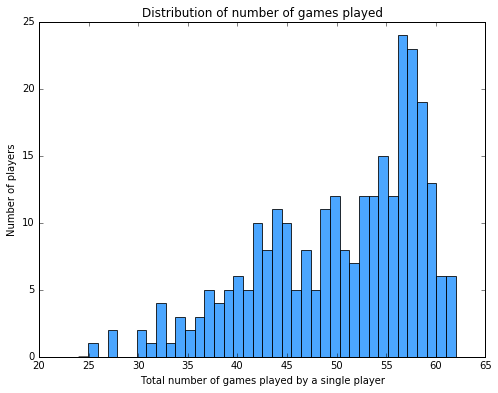

In [5]:
# There are actually data from 281 players
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 
# print 'number of unique player names:', np.unique(data['player_name'].values).shape[0]
player_id = np.unique(data['player_id'].values)
# player_name = np.unique(data['player_name'].values)

# How many unique games are there (should there be 30 * 82 / 2 = 1230 games?)
# Several players may share the same game ID (becuase they all played that night)
print 'number of unique game ID:', np.unique(data['GAME_ID'].values).shape[0]

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

In [6]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

In [7]:
print len(shots_by_player.values())


281


(128069, 2)
(281, 2)


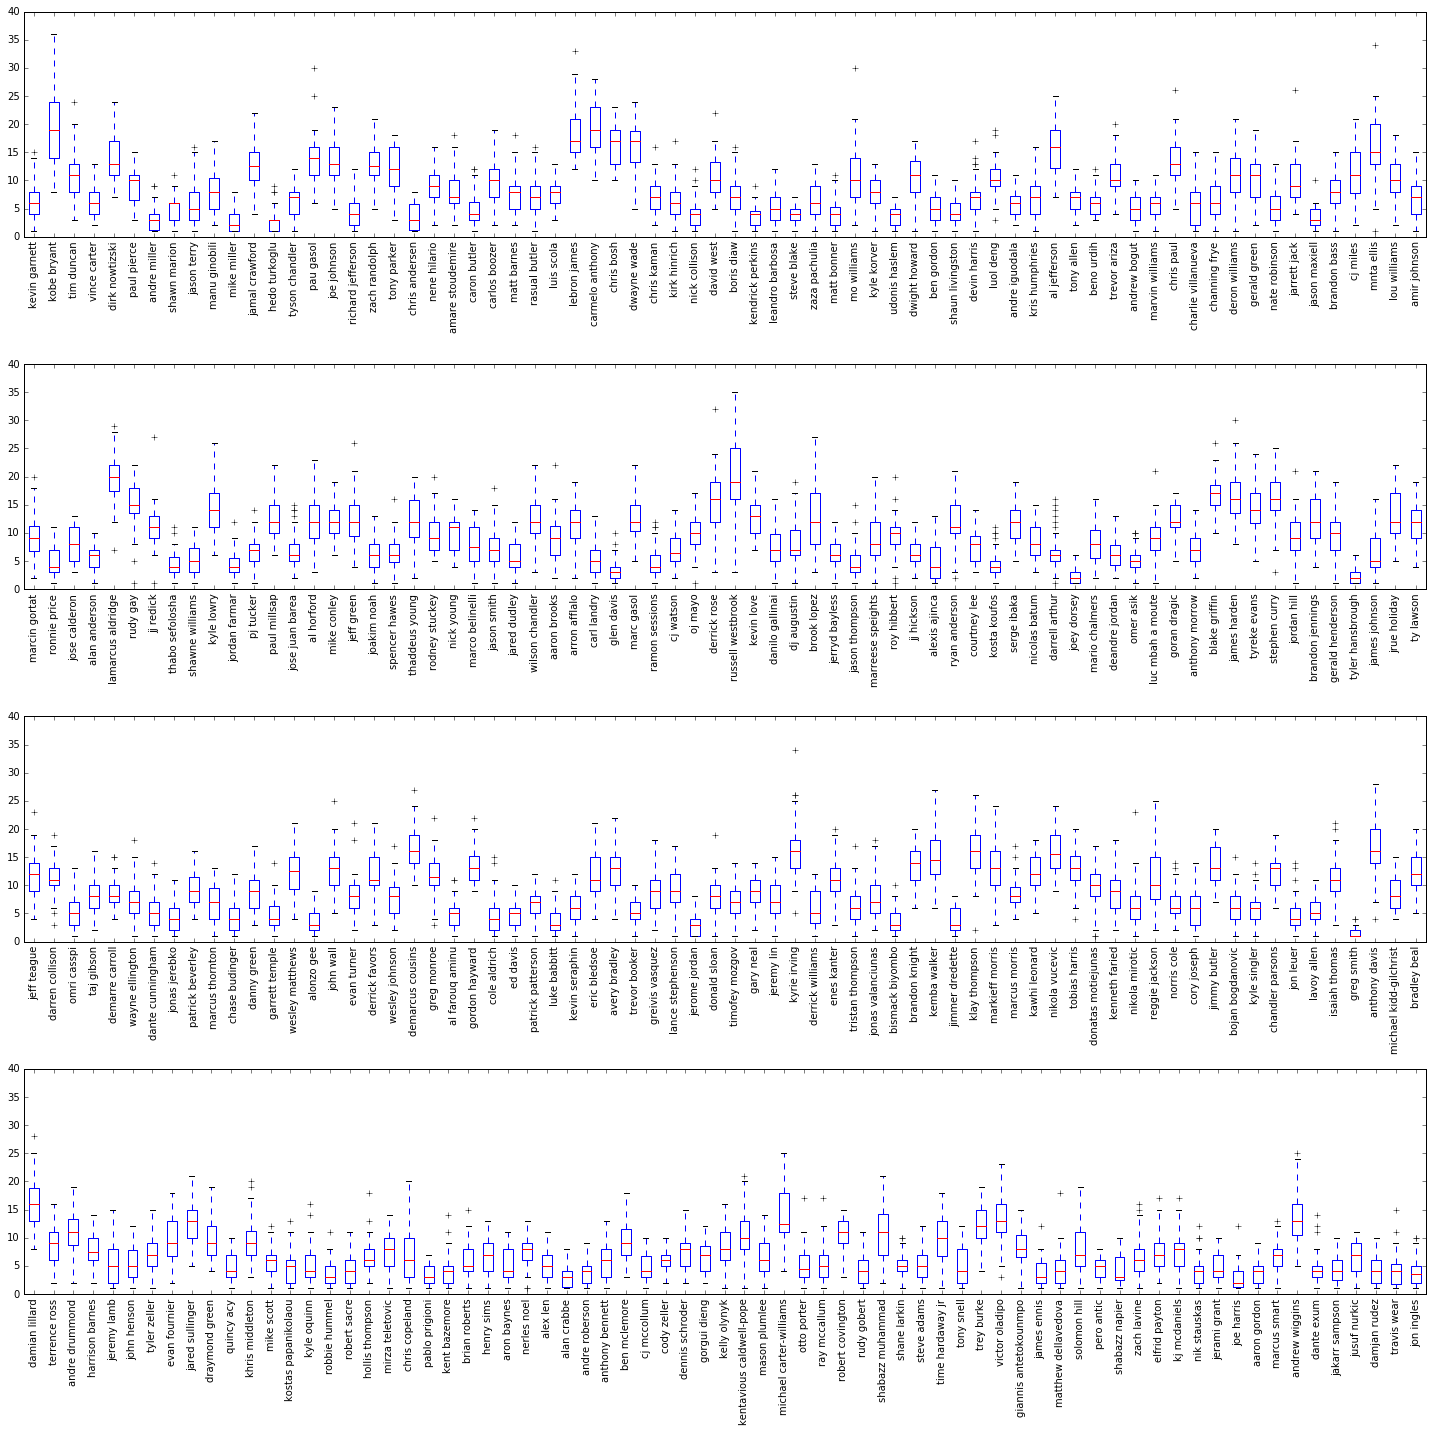

In [8]:
name_id = shots[['player_name', 'player_id']]
print name_id.shape
_, idx = np.unique(name_id['player_id'], return_index=True)
name_id = name_id.loc[idx]
print name_id.shape

# For individual players
fig, ax = plt.subplots(4,1,figsize=(20,20))
ax[0].boxplot([shots_by_player[pid] for pid in player_id[:70]])
ax[0].set_ylim((0,40))
ax[0].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[:70]], rotation='vertical')

ax[1].boxplot([shots_by_player[pid] for pid in player_id[70:140]])
ax[1].set_ylim((0,40))
ax[1].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[70:140]], rotation='vertical')

ax[2].boxplot([shots_by_player[pid] for pid in player_id[140:210]])
ax[2].set_ylim((0,40))
ax[2].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[140:210]], rotation='vertical')

ax[3].boxplot([shots_by_player[pid] for pid in player_id[210:]])
ax[3].set_ylim((0,40))
ax[3].set_xticklabels([name_id['player_name'].loc[name_id[name_id['player_id'] == idx].index[0]]
                       for idx in player_id[210:]], rotation='vertical')

plt.tight_layout()
plt.show()

How many unique shot series do we have?  10821


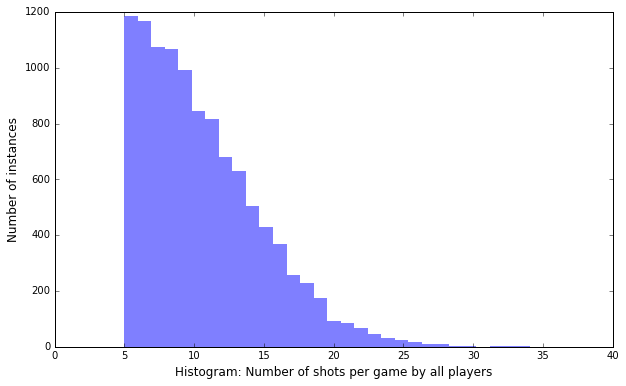

Shoot series with length smaller than 4 comprises: 0.0% of all shot series


In [341]:
# I want to come up with a better way to visualize the data above. (For individual players)
# However, for now:

# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (10,6))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5, edgecolor='none')

#ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Histogram: Number of shots per game by all players', fontsize=12)
ax.set_ylabel('Number of instances', fontsize=12)
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

#fig.savefig('points_per_game_per_player.png', bbox_inches='tight')

In [9]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [17]:
# Sanity check
#data.iloc[:20]

#### Filter out all the shot series shorter than 4

In [10]:
# Now filter out all the shot series shorter than 4
print data.shape[0]

data = data[data['shot_series_length'] > 4]
print data.shape[0] #results in loss of 10k or so shots

data.iloc[:100]

121172
111945


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,A,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,A,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,A,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
14,21400859,A,1,1,48,6.8,22.8,missed,203935,5.3,0,0,203148,5
15,21400859,A,2,2,638,6.4,24.7,made,203923,5.6,1,3,203148,5


#### Sanity Check: Did any players drop out after filtering?

number of unique player ID: 280


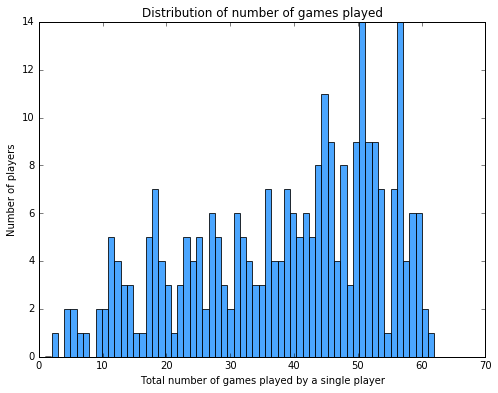

In [11]:
# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

## Part 2 - Calculating Make and Miss Streaks
by Bailey Liao


In [12]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

How many unique shot series do we have?  10821


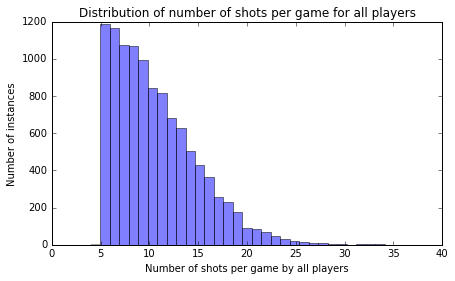

Shoot series with length smaller than 4 comprises: 0.0% of all shot series


In [13]:
# I want to come up with a better way to visualize the data above. (For individual players)
# However, for now:

# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (7,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5)

ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Number of shots per game by all players')
ax.set_ylabel('Number of instances')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [14]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] 
                                                                                      == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [15]:
# Sanity check
data.iloc[:20]

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,A,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,A,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,A,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
14,21400859,A,1,1,48,6.8,22.8,missed,203935,5.3,0,0,203148,5
15,21400859,A,2,2,638,6.4,24.7,made,203923,5.6,1,3,203148,5


number of unique player ID: 280


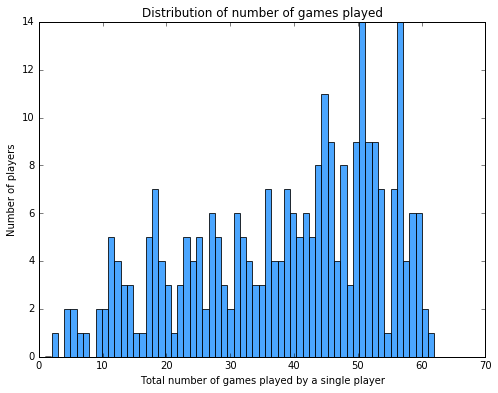

In [16]:

# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

In [17]:
#Create new dataframe so that gameID is ordered numerically
final_df = pd.DataFrame(columns=data.columns)
final_df['MAKE_STREAK'] = []
final_df.head()

group = data.groupby(['GAME_ID', 'player_id'])
#iterate through data grouped by gameid
for _, sub_df in group:
    makestreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'made'):
            count += 1
            makestreak.append(count)
        else:
            count = 0
            makestreak.append(count)
    sub_df['MAKE_STREAK'] = makestreak
    final_df = final_df.append(sub_df, ignore_index=True)
    
final_df.head()

/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK
0,21400001.0,A,1.0,1.0,191.0,17.3,20.9,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0
1,21400001.0,A,2.0,1.0,122.0,18.1,13.7,missed,201583.0,5.9,0.0,0.0,2732.0,8.0,0.0
2,21400001.0,A,3.0,1.0,29.0,21.6,22.1,missed,201936.0,2.9,0.0,0.0,2732.0,8.0,0.0
3,21400001.0,A,4.0,2.0,28.0,17.5,21.6,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0
4,21400001.0,A,5.0,3.0,209.0,15.6,14.6,made,203085.0,3.0,1.0,2.0,2732.0,8.0,1.0


In [22]:
final_df2 = pd.DataFrame(columns=final_df.columns)
final_df2['MISS_STREAK'] = []
final_df2.head()

grouped = final_df.groupby(['GAME_ID', 'player_id'])

for _, sub_df in grouped:
    missstreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'missed'):
            count += 1
            missstreak.append(count)
        else:
            count = 0
            missstreak.append(count)
    sub_df['MISS_STREAK'] = missstreak
    final_df2 = final_df2.append(sub_df, ignore_index=True)
    
final_df2.head(20)

/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK
0,21400001.0,A,1.0,1.0,191.0,17.3,20.9,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0,1.0
1,21400001.0,A,2.0,1.0,122.0,18.1,13.7,missed,201583.0,5.9,0.0,0.0,2732.0,8.0,0.0,2.0
2,21400001.0,A,3.0,1.0,29.0,21.6,22.1,missed,201936.0,2.9,0.0,0.0,2732.0,8.0,0.0,3.0
3,21400001.0,A,4.0,2.0,28.0,17.5,21.6,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0,4.0
4,21400001.0,A,5.0,3.0,209.0,15.6,14.6,made,203085.0,3.0,1.0,2.0,2732.0,8.0,1.0,0.0
5,21400001.0,A,6.0,3.0,145.0,11.7,6.4,missed,203085.0,2.2,0.0,0.0,2732.0,8.0,0.0,1.0
6,21400001.0,A,7.0,4.0,559.0,10.1,8.3,missed,202690.0,2.8,0.0,0.0,2732.0,8.0,0.0,2.0
7,21400001.0,A,8.0,4.0,216.0,11.8,25.2,missed,201569.0,3.4,0.0,0.0,2732.0,8.0,0.0,3.0
8,21400001.0,H,1.0,1.0,237.0,10.1,25.0,missed,202699.0,4.2,0.0,0.0,201583.0,21.0,0.0,1.0
9,21400001.0,H,2.0,1.0,206.0,12.4,2.7,made,202696.0,6.1,1.0,2.0,201583.0,21.0,1.0,0.0


## Part 3b - Analysis of Top 5 Players
by Zecai Liang

Based on the filtered data:
1. Generate metrics to evaluate the player's performance (1) PPG = points per game (2) FG% = FGM/FGA = field goals made per game/field goals attempted per game
2. Identify top-5 players* under each criteria, compare between the two different versions of Top 5 lists.
3. For each version of the top-5 players, visualize: (1)the distribution of shot distance among shot_made and shot_missed; (2) number of game played; (3) number of shots made per game; (4) number of shots attempted per game

(* could easily be changed to "Top n Players" with customized parameter ``top_number``, if necessary)

?? Questions for Teammates:
1. When average PPG or FG% among all the games for individual players, is it proper to use mean? 
It may be biased unless we check the distribution of each player.
2. The top-5 list coming from the two criteria are non-overlapping. How do we choose?

In [273]:
data.head(5)

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,A,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,A,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,A,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,A,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,A,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8


In [274]:
# set "Top n Player" number
top_number = 5

In [275]:
### ------------------------------------ 1. Generating Metrics ---------------------------------

# group data by player_id, then by game_id
player_game_group = data.groupby(["player_id","GAME_ID"])

   player_id   GAME_ID  PTS
0        708  21400006   10
1        708  21400033   14
2        708  21400044    6
3        708  21400060    2
4        708  21400090    4
   player_id        PTS
0        708   7.030303
1        977  16.352941
2       1495  11.196078
3       1713   6.500000
4       1717  13.894737

Top 5 Players by PPG criteria:
   index  player_id        PTS
0     27       2544  19.803922
1    132     201939  19.491228
2    105     201566  19.444444
3     28       2546  18.789474
4    187     202691  18.543860


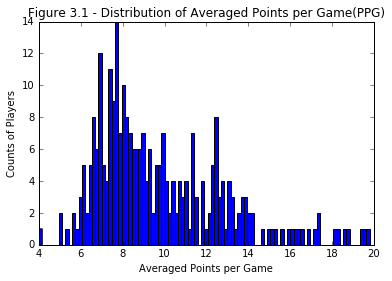

In [276]:
## ------------------------------------ Criteria 1: PPG ----------------------------------------

# points for each game of each player
player_game_ppg = player_game_group["PTS"].sum().reset_index()
print player_game_ppg.head()

# average points among games for each player 
player_ppg = player_game_ppg.groupby("player_id")["PTS"].mean().reset_index()
print player_ppg.head()

# select top n players by PPG
player_ppg_top = player_ppg.sort_values(by="PTS", ascending=False).reset_index()
print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# visualize the distribution of PPG for all the players
plt.hist(player_ppg_top["PTS"], bins=100)
plt.title("Figure 3.1 - Distribution of Averaged Points per Game(PPG)")
plt.xlabel("Averaged Points per Game")
plt.ylabel("Counts of Players")
plt.show()

In [296]:
player_ppg_top.sort_values(by='PTS', ascending=False)['PTS'][0:5]

0    19.803922
1    19.491228
2    19.444444
3    18.789474
4    18.543860
Name: PTS, dtype: float64

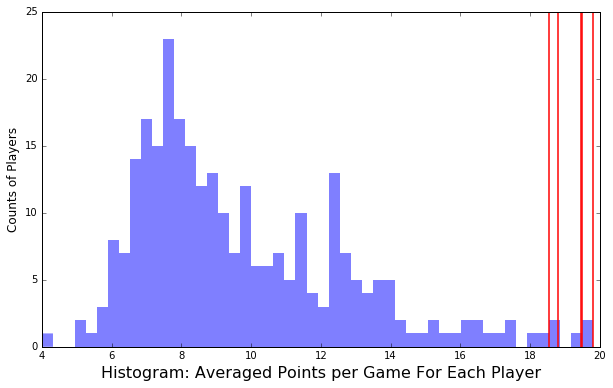

In [356]:
# plot modified for Poster
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(player_ppg_top["PTS"], bins=50, alpha=0.5, edgecolor='none')
for i in player_ppg_top.sort_values(by='PTS', ascending=False)['PTS'][0:5]:
    plt.axvline(i, lw=1.5, ls="-", color="red")
#plt.title("Figure 3.1 - Distribution of Averaged Points per Game(PPG)")
plt.xlabel("Histogram: Averaged Points per Game For Each Player", fontsize=16)
plt.ylabel("Counts of Players", fontsize=12)
plt.show()

#fig.savefig('points_per_game_per_player.png', bbox_inches='tight')

   player_id   GAME_ID       FG%
0        708  21400006  0.625000
1        708  21400033  0.500000
2        708  21400044  0.375000
3        708  21400060  0.142857
4        708  21400090  0.250000
   player_id       FG%
0        708  0.461204
1        977  0.387361
2       1495  0.497707
3       1713  0.353841
4       1717  0.470222

Top 5 Players by FG criteria:
   index  player_id       FG%
0    124     201599  0.710055
1     13       2199  0.692956
2      6       1889  0.650072
3    137     201949  0.649858
4    246     203486  0.622819


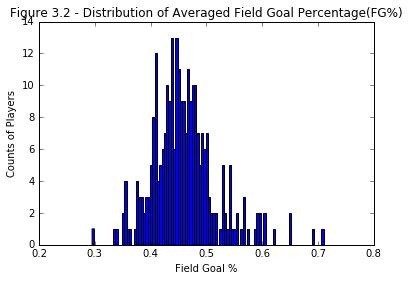

In [277]:
## ------------------------------------ Criteria 2: FG% ----------------------------------------

# FG% for each game of each player
player_game_fg_raw = player_game_group["FGM"].sum() / player_game_group["FGM"].size()
player_game_fg = player_game_fg_raw.reset_index()
player_game_fg.columns.values[2] = "FG%"
print player_game_fg.head()

# average FG% among games for each player 
player_fg = player_game_fg.groupby("player_id")["FG%"].mean().reset_index()
print player_fg.head()

# select top n players by FG%
player_fg_top = player_fg.sort_values(by="FG%", ascending=False).reset_index()
print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))

# visualize the distribution of FG% for all the players
plt.hist(player_fg_top["FG%"], bins=100)
plt.title("Figure 3.2 - Distribution of Averaged Field Goal Percentage(FG%)")
plt.xlabel("Field Goal %")
plt.ylabel("Counts of Players")
plt.show()

In [278]:
### ----------------------------  2. Compare Two Versions of Top Lists -------------------------
    # top list by PPG: saved as DataFrame "player_ppg_top"
    # top list by FG%: saved as DataFrame "player_fg_top"

# Extract the Top 5 Players' (by PPG) Ranking under FG% Metrics (the alter_rank starts from 0)
alter_rank_fg = np.array([], dtype="int64")

for player in player_ppg_top["player_id"]:
    rank = player_fg_top[player_fg_top["player_id"] == player].index.values
    alter_rank_fg = np.append(alter_rank_fg,[rank])

player_ppg_top["alter_rank_by_FG"] = alter_rank_fg

print "\n", "Top %d Players by PPG criteria:" % top_number
print player_ppg_top.head(int(top_number))

# Extract the Top 5 Players' (by FG%) Ranking under PPG Metrics (the alter_rank starts from 0)
alter_rank_ppg = np.array([], dtype="int64")

for player in player_fg_top["player_id"]:
    rank = player_ppg_top[player_ppg_top["player_id"] == player].index.values
    alter_rank_ppg = np.append(alter_rank_ppg,[rank])

player_fg_top["alter_rank_by_PPG"] = alter_rank_ppg

print "\n", "Top %d Players by FG criteria:" % top_number
print player_fg_top.head(int(top_number))


Top 5 Players by PPG criteria:
   index  player_id        PTS  alter_rank_by_FG
0     27       2544  19.803922                59
1    132     201939  19.491228                56
2    105     201566  19.444444               149
3     28       2546  18.789474               139
4    187     202691  18.543860               109

Top 5 Players by FG criteria:
   index  player_id       FG%  alter_rank_by_PPG
0    124     201599  0.710055                101
1     13       2199  0.692956                 90
2      6       1889  0.650072                154
3    137     201949  0.649858                 71
4    246     203486  0.622819                 97


We can see from the above chart that the two versions of the Top 5 List varies a lot,
and players who rank high by one criteria don't have high ranking under the other criteria.

In [279]:
### -------------------------------------  3. Visulization --------------------------------------------

## (1) Shot_Distance of Shot_Result_Made and Shot_Result_Missed, for all layers VS top players

    # distance of shot_made, all players
data_shotdist_made = data[data["SHOT_RESULT"] == "made"]["SHOT_DIST"]
     # distance of shot_mmissed, all players
data_shotdist_miss = data[data["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_ppg = data[data["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by PPG
data_top_ppg_shotdist_made = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by PPG
data_top_ppg_shotdist_miss = data_top_ppg[data_top_ppg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

data_top_fg = data[data["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]
    # distance of shot_made, top 5 players by FG%
data_top_fg_shotdist_made = data_top_fg[data_top_fg["SHOT_RESULT"] == "made"]["SHOT_DIST"]
    # distance of shot_missed, top 5 players by FG%
data_top_fg_shotdist_miss = data_top_fg[data_top_fg["SHOT_RESULT"] == "missed"]["SHOT_DIST"]

Figure 3.3 - The Distribution of Shot Distance:


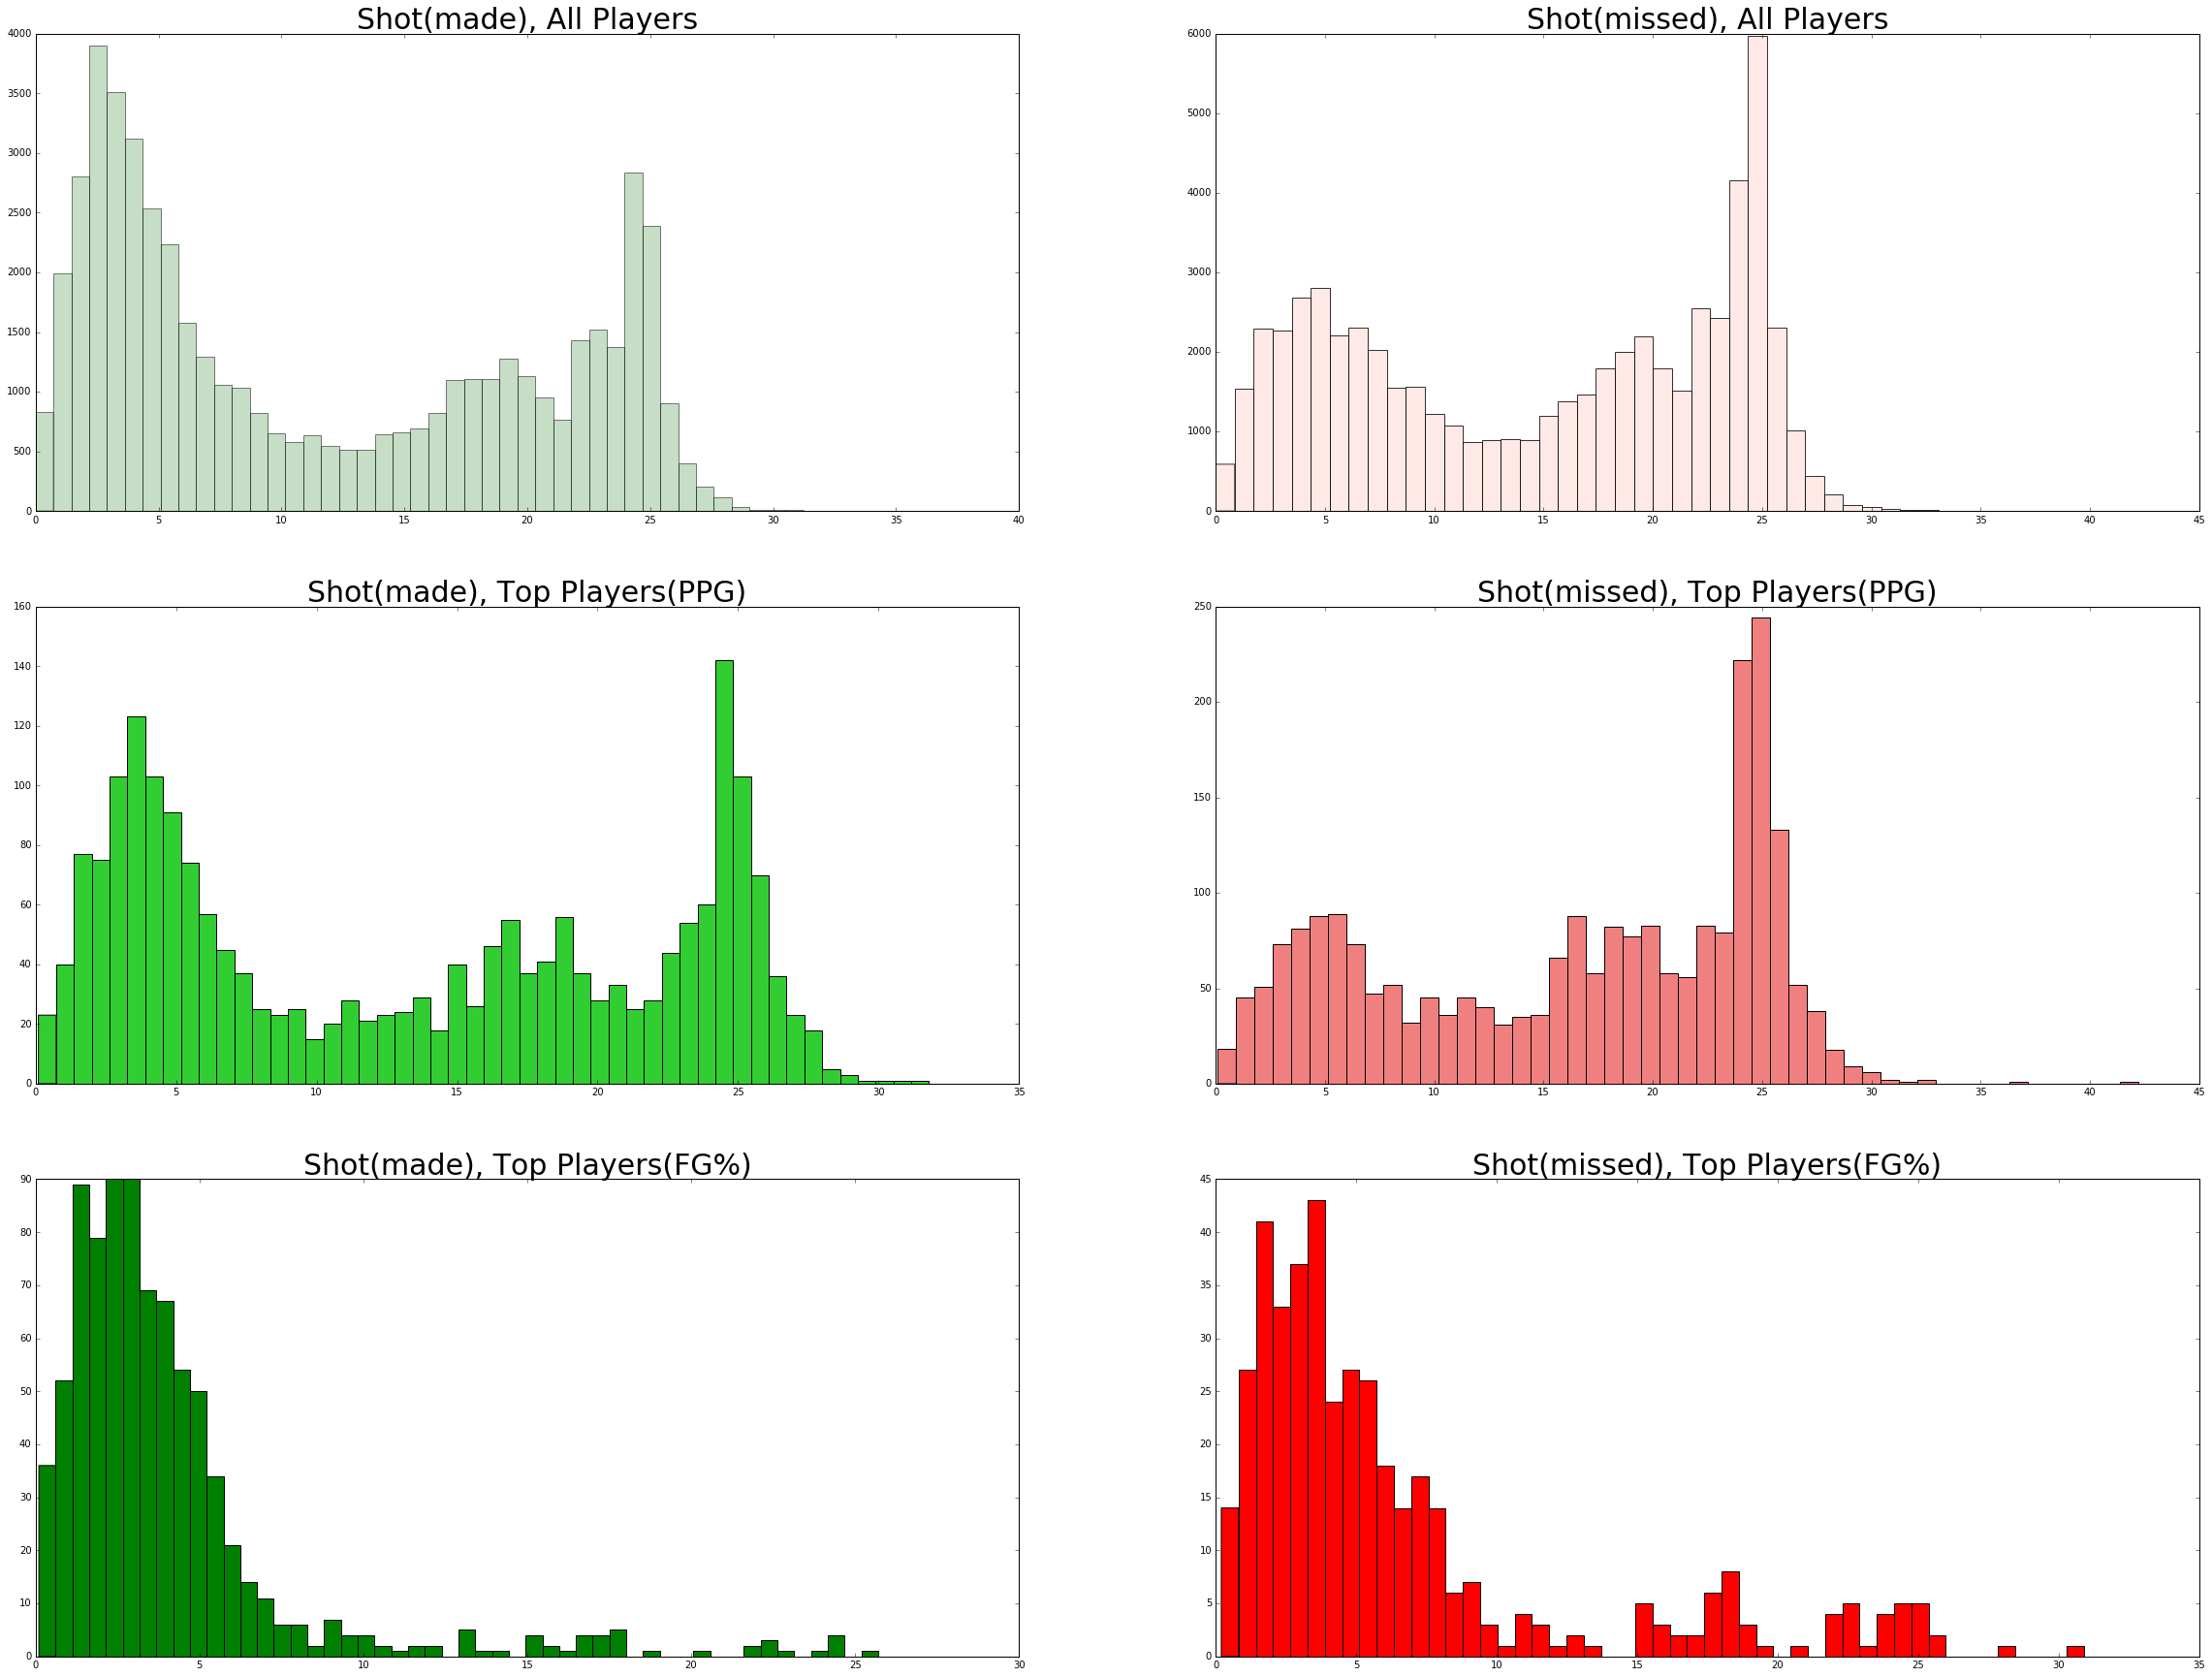

In [280]:
print "Figure 3.3 - The Distribution of Shot Distance:"

fig, ax = plt.subplots(3,2,figsize=(40,30))
ax[0,0].hist(data_shotdist_made, bins=50, color="DarkSeaGreen", alpha=0.5, label="All Players")
ax[0,0].set_title("Shot(made), All Players", fontsize=30)
ax[1,0].hist(data_top_ppg_shotdist_made, bins=50, color="limegreen", label="Top Players by PPG")
ax[1,0].set_title("Shot(made), Top Players(PPG)", fontsize=30)
ax[2,0].hist(data_top_fg_shotdist_made, bins=50, color="green", label="Top Players by FG%")
ax[2,0].set_title("Shot(made), Top Players(FG%)", fontsize=30)

ax[0,1].hist(data_shotdist_miss, bins=50, color="mistyrose", alpha=0.8, label="All Players")
ax[0,1].set_title("Shot(missed), All Players", fontsize=30)
ax[1,1].hist(data_top_ppg_shotdist_miss, bins=50, color="lightcoral", label="Top Players by PPG")
ax[1,1].set_title("Shot(missed), Top Players(PPG)", fontsize=30)
ax[2,1].hist(data_top_fg_shotdist_miss, bins=50, color="red", label="Top Players by FG%")
ax[2,1].set_title("Shot(missed), Top Players(FG%)", fontsize=30)

plt.show()

We can tell from the above visualization that players with high FG% tend to shot from a cloer distance, no matter if the shots are made or missed.

In [330]:
## (2)Number of Game Played, for all layers VS top players

    # number of game played, all players
data_game = data[["player_id","GAME_ID"]].groupby("player_id").GAME_ID.nunique()

    # number of game played, top 5 players by PPG
data_top_ppg_game = data_top_ppg[["player_id","GAME_ID"]].groupby("player_id").GAME_ID.nunique()

    # number of game played, top 5 players by FG%
data_top_fg_game = data_top_fg[["player_id","GAME_ID"]].groupby("player_id").GAME_ID.nunique()

In [337]:
data[["player_id","GAME_ID"]].groupby("player_id").GAME_ID.nunique().sum()

10821

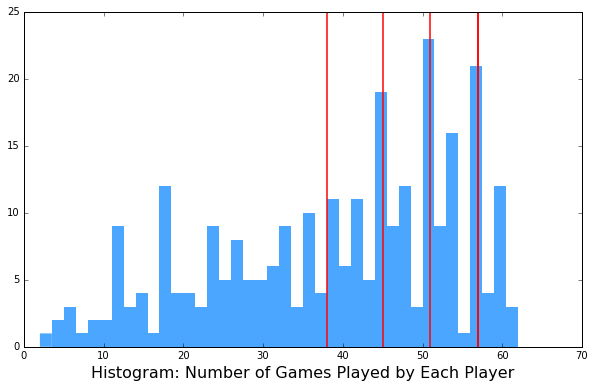

Game Played by the Top Players (PPG), marked by orange:
player_id
2544      51
2546      38
201566    45
201939    57
202691    57
Name: GAME_ID, dtype: int64 

Game Played by the Top Players (FG%), marked by red:
player_id
1889      11
2199      36
201599    46
201949    27
203486    41
Name: GAME_ID, dtype: int64


In [355]:
# plot modified for Poster
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(games_per_player, bins=40, color="dodgerblue", alpha=0.8, edgecolor='none')
#plt.title("Figure 3.4 - Distribution of Gamed played among All Players")
plt.xlabel("Histogram: Number of Games Played by Each Player", fontsize=16)

for i in data_top_ppg_game:
    plt.axvline(i, lw=1.5, ls="-", color="red")
#for i in data_top_fg_game:
#   plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Game Played by the Top Players (PPG), marked by orange:"
print data_top_ppg_game, "\n"

print "Game Played by the Top Players (FG%), marked by red:"
print data_top_fg_game

fig.savefig('game_per_player.png', bbox_inches='tight')

We can see that the Top 5 Player (by FG%) don't play many games in general.

In [ ]:
## (3)FGM (field goal make) per Game, for all layers VS top players (optional)
    # average FGM for all the players
player_game_fgm = player_game_group["FGM"].sum().reset_index()
player_fgm = player_game_fgm.groupby(["player_id"])["FGM"].mean().reset_index()

    # average FGM for top players (by PPG)
player_top_ppg_fgm = player_fgm[player_fgm["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGM for top players (by FG%)
player_top_fg_fgm = player_fgm[player_fgm["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

In [ ]:
plt.hist(player_fgm["FGM"], bins=40, color="black", alpha=0.5)
plt.title("Figure 3.5 - Distribution of FGM among All Players")
plt.xlabel("Field Goal Made")
for i in player_top_ppg_fgm["FGM"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fgm["FGM"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGM for top players (by PPG), marked by orange:"
print player_top_ppg_fgm,"\n"

print "Average FGM for top players (by FG%), marked by red:"
print player_top_fg_fgm

In [ ]:
## (4)FGA (field goal attempted) per Game, for all layers VS top players (optional)

    # average FGA for all the players
player_game_fga = player_game_group["FGM"].size().reset_index()
player_game_fga.columns.values[2] = "FGA"
player_fga = player_game_fga.groupby(["player_id"])["FGA"].mean().reset_index()

    # average FGA for top players (by PPG)
player_top_ppg_fga = player_fga[player_fga["player_id"].isin(player_ppg_top.head(int(top_number))["player_id"].values)]

    # average FGA for top players (by FG%)
player_top_fg_fga = player_fga[player_fga["player_id"].isin(player_fg_top.head(int(top_number))["player_id"].values)]

In [ ]:
plt.hist(player_fga["FGA"], bins=40, color="black", alpha=0.3)
plt.title("Figure 3.6 - Distribution of FGA among All Players")
plt.xlabel("Field Goal Attempted")
for i in player_top_ppg_fga["FGA"]:
    plt.axvline(i, lw=1.3, ls="--", color="orangered")
for i in player_top_fg_fga["FGA"]:
    plt.axvline(i, lw=1.5, ls="--", color="crimson")
plt.show()

print "Average FGA for top players (by PPG), marked by orange:"
print player_top_ppg_fga,"\n"

print "Average FGA for top players (by FG%), marked by red:"
print player_top_fg_fga

We can see from the two visualizations above: top players (by FG%) temp to make less FGA and also FGM; while top players (by PPG) top at these two metrics.

### *Plots for poster
- Distribution of Number od Shots Made

by Zecai

In [473]:
## Histogram: Number of Shots
shot_number = data[["player_id","GAME_ID","SHOT_NUMBER"]].groupby(["player_id","GAME_ID"]).count()
shot_number_top = data_top_ppg[["player_id","GAME_ID","SHOT_NUMBER"]].groupby(["player_id","GAME_ID"]).count()

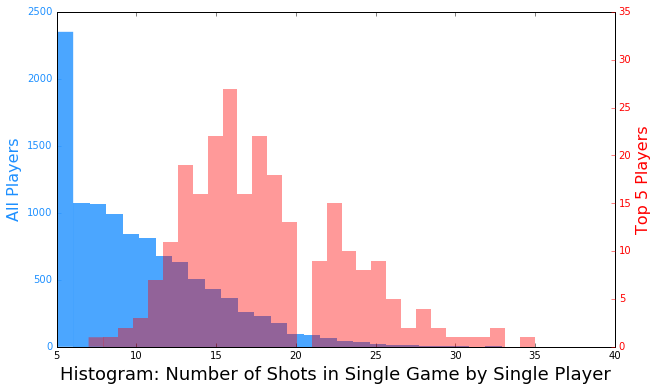

In [511]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.hist(shot_number['SHOT_NUMBER'], bins=30, color="dodgerblue", alpha=0.8, edgecolor='none')
ax1.set_ylabel("All Players", color="dodgerblue", fontsize=16)
ax1.tick_params(axis='y', colors="dodgerblue")
ax1.set_xlabel("Histogram: Number of Shots in Single Game by Single Player", fontsize=18)

ax2 = ax1.twinx()
ax2.hist(shot_number_top['SHOT_NUMBER'], bins=30, color="red", alpha=0.4, edgecolor='none')
ax2.set_ylabel("Top 5 Players", color='red', fontsize=16)
ax2.tick_params(axis='y', colors="red")
ax2.set_ylim([0,35])

#plt.title("Distribution of Shots in Single Game by Single Players")

plt.xlim([5,40])

plt.show()

#fig.savefig('shot_number_per_game_per_player.png', bbox_inches='tight')

### *Plots for poster
- Distribution of the Length of Make_Streak and Miss_Streak

by Zecai

In [652]:
def find_streak_length(data, feature_name):
    data_raw = data[feature_name][data[feature_name] != 0]

    streak_length = np.array([])

# save the lenght of each streak
    for i in np.arange(len(data_raw)-1):
        if (data_raw.iloc[i+1] - data_raw.iloc[i]) != 1:
            streak_length = np.append(streak_length, data_raw.iloc[i])

    streak_length = np.append(streak_length, data_raw.iloc[-1])
    
    return streak_length

In [653]:
# length of the make/miss streak
make_streak_length = find_streak_length(final_df2,"MAKE_STREAK")
miss_streak_length = find_streak_length(final_df2,"MISS_STREAK")

make_length, make_counts = np.unique(make_streak_length, return_counts=True)
miss_length, miss_counts = np.unique(miss_streak_length, return_counts=True) 

In [660]:
player_ppg_top['player_id'][0:5]

0      2544
1    201939
2    201566
3      2546
4    202691
Name: player_id, dtype: int64

In [665]:
# Top5 player, length of the make/miss streak
top5_data = pd.DataFrame({})

for id in player_ppg_top['player_id'][0:5]:
    top_data = final_df2[final_df2['player_id'] == 2544]
    top5_data = pd.concat([top5_data, top_data])   

In [666]:
top5_make_streak = find_streak_length(top5_data,"MAKE_STREAK")
top5_miss_streak = find_streak_length(top5_data,"MISS_STREAK")

top5_make_legnth, top5_make_count = np.unique(top5_make_streak, return_counts=True)
top5_miss_legnth, top5_miss_count = np.unique(top5_miss_streak, return_counts=True)

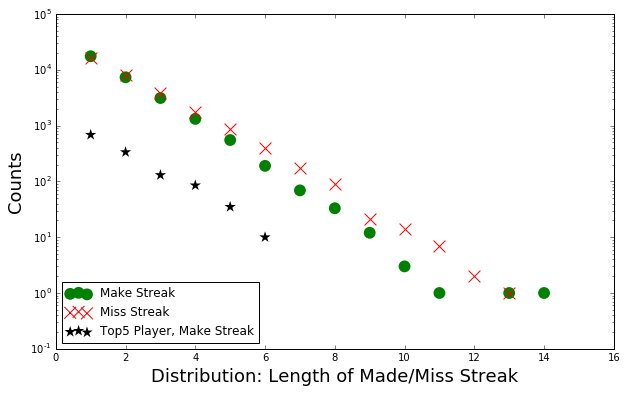

In [676]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(make_length, make_counts, color="green", marker='o', s=140, edgecolor='none', label='Make Streak')
ax.scatter(miss_length, miss_counts, color="red", marker='x', s=140, edgecolor='none', label='Miss Streak')
ax.scatter(top5_make_legnth,  top5_make_count, color="black", marker='*', s=140, edgecolor='none', label='Top5 Player, Make Streak')

#ax.hist(made_streak_length, bins=20, color="red", alpha=0.6, edgecolor='none')
#ax.set_ylabel("All Players", color="dodgerblue", fontsize=16)
#ax.tick_params(axis='y', colors="dodgerblue")
#ax.set_xlabel("Histogram: Number of Shots in Single Game by Single Player", fontsize=18)

#ax.hist(shot_number_top['SHOT_NUMBER'], bins=30, color="red", alpha=0.4, edgecolor='none')
#ax.set_ylabel("Top 5 Players", color='red', fontsize=16)
#ax.tick_params(axis='y', colors="red")

#plt.title("Distribution of Shots in Single Game by Single Players")
plt.xlabel('Distribution: Length of Made/Miss Streak', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.yscale('log')
plt.legend(loc=3)
plt.show()

fig.savefig('stream_length.png', bbox_inches='tight')

For the top 5 players, analyze how well the streak of made and missed shots can predict whether the player makes a shot ('FGM')

In [681]:
top5_player_id = [2544, 201939, 201566, 2546, 202691]
final_df2.head(3)

### Making sure that the top five players make sense #HTH
print 'The top five players are:'
for player_id in top5_player_id:
    print '{}: {:s}'.format(player_id, name_id['player_name'][name_id['player_id'] == player_id].values[0])

The top five players are:
2544: lebron james
201939: stephen curry
201566: russell westbrook
2546: carmelo anthony
202691: klay thompson


In [682]:

# HTH
# Subset the data dataframe to contain only the top 5 players
print data.shape
data_top5 = data[(data['player_id'] == 2544) |
                 (data['player_id'] == 201939) |
                 (data['player_id'] == 201566) |
                 (data['player_id'] == 2546) |
                 (data['player_id'] == 202691)]
data_top5 = data_top5.reset_index(drop=True)
print data_top5.shape

# Create 3 columns to store the streat metrics
data_top5.loc[:, 'serie_id'] = np.nan # Each player has his set if serie_id starting from 1
data_top5.loc[:, 'MAKE_STREAK'] = np.nan # Number of cumulative shots made, 0 if miss
data_top5.loc[:, 'MISS_STREAK'] = np.nan # Number of cumulative shots missed, 0 if make
data_top5.loc[:, 'streak_metric'] = np.nan # MAKE_STREAK - MISS_STREAK

print data_top5.shape
data_top5[:5]

(111945, 14)
(4489, 14)
(4489, 18)


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,serie_id,MAKE_STREAK,MISS_STREAK,streak_metric
0,21400907,H,1,1,589,16.3,8.0,missed,203507,2.5,0,0,201939,14,NaN,NaN,NaN,NaN
1,21400907,H,2,1,446,16.6,25.9,missed,203487,3.0,0,0,201939,14,NaN,NaN,NaN,NaN
2,21400907,H,3,1,334,11.0,23.8,made,101141,7.5,1,3,201939,14,NaN,NaN,NaN,NaN
3,21400907,H,4,1,300,18.5,27.5,made,203487,6.4,1,3,201939,14,NaN,NaN,NaN,NaN
4,21400907,H,6,1,11,3.0,25.1,missed,203089,4.8,0,0,201939,14,NaN,NaN,NaN,NaN


In [684]:
## HTH
## Fill in the streat metrics

# To keep track whether we are within the same game of the same player
p = data_top5.loc[0, 'player_id']
g = data_top5.loc[0, 'GAME_ID']

# Tracker
serie = 0

for index, row in data_top5.iterrows():
    if (p == row['player_id']) & (g == row['GAME_ID']):
        data_top5.loc[index, 'serie_id'] = serie
    elif (p == row['player_id']) & (g != row['GAME_ID']):
        g = row['GAME_ID']
        serie += 1
        data_top5.loc[index, 'serie_id'] = serie 
    elif (p != row['player_id']) & (g == row['GAME_ID']):
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie
    else:
        g = row['GAME_ID']
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie

# Tracker
hit_count = 0
miss_count = 0
serie = data_top5.loc[0, 'serie_id']

for index, row in data_top5.iterrows():
    if serie == row['serie_id']:
        if row['SHOT_RESULT'] == 'made':
            hit_count += 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count += 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
    else:
        serie = row['serie_id']
        
        if row['SHOT_RESULT'] == 'made':
            hit_count = 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count = 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count

data_top5[:5]

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,serie_id,MAKE_STREAK,MISS_STREAK,streak_metric
0,21400907,H,1,1,589,16.3,8.0,missed,203507,2.5,0,0,201939,14,0.0,0.0,1.0,-1.0
1,21400907,H,2,1,446,16.6,25.9,missed,203487,3.0,0,0,201939,14,0.0,0.0,2.0,-2.0
2,21400907,H,3,1,334,11.0,23.8,made,101141,7.5,1,3,201939,14,0.0,1.0,0.0,1.0
3,21400907,H,4,1,300,18.5,27.5,made,203487,6.4,1,3,201939,14,0.0,2.0,0.0,2.0
4,21400907,H,6,1,11,3.0,25.1,missed,203089,4.8,0,0,201939,14,0.0,0.0,1.0,-1.0


Using basic predictors shot_clock, shot_dist, and close_def_dist, which are decent representative markers of shot difficulty, logistic regression correctly predicts whether a shot is made or missed roughly 60% of the time. There is no significant difference between prediction of shots made at home vs away games. Looking at the most successful make_streak of 13 shots made in a row by a top5 player (selected by most points per game ie PPG), the model trained to the entire dataaset by cross validation only results in a score of 0.48, meaning that based on the broader training set for this particular streak more that half the shots that were made were expected to be missed by the trained model. 

## Part 3 - Classification Model to Predict "FGM" 

by Zecai

Suppose that each individual shot is independent, pull data of all the shots in dataframe "final_df2" and build model to predict "FGM".

selected predictors: [ 'LOCATION', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']

excluded predictors: ['GAME_ID', 'SHOT_NUMBER','CLOSEST_DEFENDER_PLAYER_ID', 'player_id']

Models:
1. Logistic Regression
2. LDA
3. QDA
4. KNN
5. SVM
6. RF

In [23]:
final_df2.head()

,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK
0,21400001.0,A,1.0,1.0,191.0,17.3,20.9,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0,1.0
1,21400001.0,A,2.0,1.0,122.0,18.1,13.7,missed,201583.0,5.9,0.0,0.0,2732.0,8.0,0.0,2.0
2,21400001.0,A,3.0,1.0,29.0,21.6,22.1,missed,201936.0,2.9,0.0,0.0,2732.0,8.0,0.0,3.0
3,21400001.0,A,4.0,2.0,28.0,17.5,21.6,missed,201569.0,3.6,0.0,0.0,2732.0,8.0,0.0,4.0
4,21400001.0,A,5.0,3.0,209.0,15.6,14.6,made,203085.0,3.0,1.0,2.0,2732.0,8.0,1.0,0.0


In [25]:
final_df2.columns

Index([u'GAME_ID', u'LOCATION', u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK',
       u'SHOT_CLOCK', u'SHOT_DIST', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST', u'FGM', u'PTS',
       u'player_id', u'shot_series_length', u'MAKE_STREAK', u'MISS_STREAK'],
      dtype='object')

In [38]:
## convert categorical predictors ['LOCATION', 'PERIOD'] to dummy variables
mask = ['GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']
final_df2_model = final_df2[mask]

    # convert LOCATION'
final_df2_location = pd.get_dummies(final_df2['LOCATION'], prefix='LOCATION')
final_df2_model = pd.concat([final_df2_model, final_df2_location], axis=1)
    # convert 'PERIOD'
final_df2_period = pd.get_dummies(final_df2['PERIOD'], prefix='PERIOD')
final_df2_model = pd.concat([final_df2_model, final_df2_period], axis=1)

In [39]:
final_df2_model.head()

,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,LOCATION_A,LOCATION_H,PERIOD_1.0,PERIOD_2.0,PERIOD_3.0,PERIOD_4.0,PERIOD_5.0,PERIOD_6.0,PERIOD_7.0
0,191.0,17.3,20.9,3.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,122.0,18.1,13.7,5.9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29.0,21.6,22.1,2.9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28.0,17.5,21.6,3.6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,209.0,15.6,14.6,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [40]:
## Standardize and Extract Predictors
x_unscale = final_df2_model
x = preprocessing.scale(x_unscale)
y = final_df2['FGM']

In [42]:
# to examine baseline score, alway split at ratio 0.33
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.33, random_state=0)

In [738]:
### check balance
print 'Size of Whole Dataset:', final_df2.shape[0]
print "Number of Made Shots in Whole Dataset:", final_df2[final_df2['FGM'] == 1].shape[0]
print "Number of Missed Shots in Whole Dataset:", final_df2[final_df2['FGM'] == 0].shape[0]
print final_df2[final_df2['FGM'] == 1].shape[0]/float(final_df2.shape[0])
print final_df2[final_df2['FGM'] == 0].shape[0]/float(final_df2.shape[0])

Size of Whole Dataset: 111945
Number of Made Shots in Whole Dataset: 51637
Number of Missed Shots in Whole Dataset: 60308
0.461271159945
0.538728840055


### 3.1 Logistic Regression

In [44]:
## Baseline
lr = LogReg()
lr.fit(x_train, y_train)
print "Baseline score of Logistic Regression:", lr.score(x_test, y_test)

Baseline score of Logistic Regression: 0.597558334687


In [106]:
## feature selection
print "Features:", final_df2_model.columns.values
print 'Coeificiency:', lr.coef_

 Features: ['GAME_CLOCK' 'SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST' 'LOCATION_A'
 'LOCATION_H' 'PERIOD_1.0' 'PERIOD_2.0' 'PERIOD_3.0' 'PERIOD_4.0'
 'PERIOD_5.0' 'PERIOD_6.0' 'PERIOD_7.0']
Coeificiency: [[ -3.80549934e-03   9.83914051e-02  -5.18852872e-01   3.11677169e-01
   -8.24234236e-03   8.24234236e-03   4.21999547e-03  -3.02292538e-03
    1.03861370e-02  -7.94212242e-03  -2.08045445e-02   2.85473986e-05
   -3.79658484e-03]]


In [77]:
## K-fold Cross Validation to Tune Regularization (C)
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
lr_cv_score = []

for c in c_values:
    cv_score = []
    model = LogReg(C=c) 
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    lr_cv_score.append(np.mean(cv_score))   

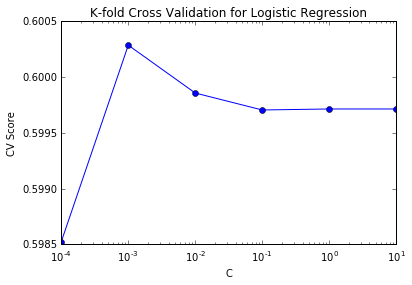

In [152]:
# visualization of k-fold CV
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
plt.semilogx(c_values, lr_cv_score,'bo-')
plt.xlabel("C")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for Logistic Regression")
plt.show()

In [153]:
print 'Optimized Score of Logistic Regression:', lr_cv_score[1]

Optimized Score of Logistic Regression: 0.600285854661


In [225]:
## Tuned Model
lr_op = LogReg(C=0.001)
lr_op.fit(x_train, y_train)

In [244]:
LR_rank = pd.DataFrame({'feature': features.tolist(),
                       'coef': lr_op.coef_[0] })

LR_rank_sort = LR_rank.sort_values(by='coef', ascending=False)

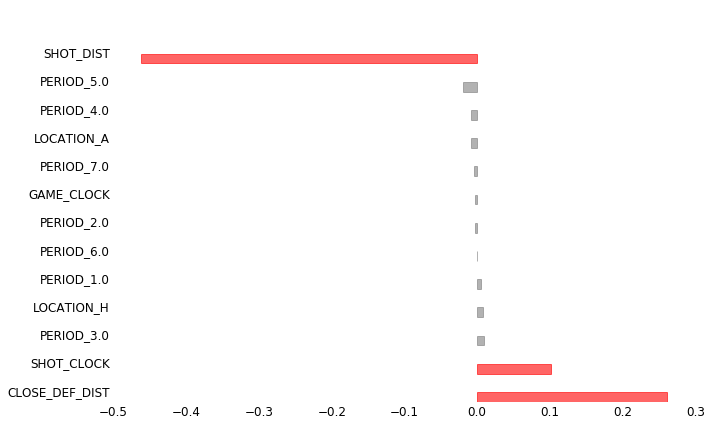

In [425]:
## plot feature importance
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(features))
bar_width = 0.35
opacity = 0.6

plt.barh(index, LR_rank_sort['coef'], bar_width,
                 alpha=opacity,
                 color=['red','red','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','red'],
                 edgecolor=['red','red','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','red'])
 
#plt.xlabel('Score', fontsize=14)
#plt.ylabel('Models', fontsize=14)
#plt.title('Feature Importance by Coefficiency (LogReg Model)', fontsize=16)
plt.yticks(index + bar_width, LR_rank_sort['feature'], fontsize=12, color='k')
plt.xticks(fontsize=12, color='k')
#plt.legend()
plt.grid(False)

# remove frame
ax.set_frame_on(False)
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
plt.tight_layout()
plt.show()

#fig.savefig('feature_importance.png', bbox_inches='tight')

### 3.2 LDA

In [45]:
## Baseline
lda = LDA()
lda.fit(x_train, y_train)
print "Baseline score of LDA:", lda.score(x_test, y_test)

Baseline score of LDA: 0.597179362244


/Users/CC/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### 3.2 QDA

In [46]:
## Baseline
qda = QDA()
qda.fit(x_train, y_train)
print "Baseline score of QDA:", qda.score(x_test, y_test)

Baseline score of QDA: 0.467137675275


/Users/CC/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 3.3 KNN

In [48]:
## Baseline
neigh = KNN(n_neighbors=5)
neigh.fit(x_train, y_train)
print "Baseline score of KNN:", neigh.score(x_test, y_test)

 Baseline score of KNN: 0.554057712089


In [85]:
## K-fold Cross Validation to Tune K
k_values = [10, 50, 100, 200, 300, 400]
knn_cv_score = []

for k in k_values:
    cv_score = []
    model = KNN(n_neighbors=k) 
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    knn_cv_score.append(np.mean(cv_score))  

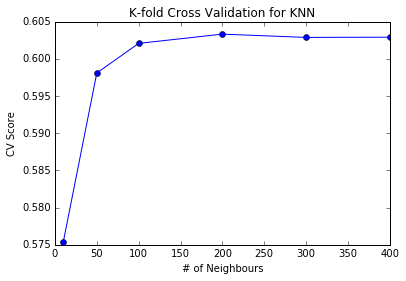

In [730]:
# visualization of k-fold CV
plt.plot(k_values, knn_cv_score,'bo-')
plt.xlabel("# of Neighbours")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for KNN")
plt.show()

In [154]:
print 'Optimzied Score of KNN:', knn_cv_score[3]

Optimzied Score of KNN: 0.603314127473


### 3.4 SVM

In [49]:
## Baseline, guassian kernel
svm = SVC(kernel='rbf', random_state=0)
svm.fit(x_train, y_train)
print "Baseline score of SVM (rbf kernel):", svm.score(x_test, y_test)

Baseline score of SVM: 0.609983216935


In [437]:
## Baseline, feature importance
print "Features:", final_df2_model.columns.values
print 'Feature Importance:', svm.coef_

 Features: ['GAME_CLOCK' 'SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST' 'LOCATION_A'
 'LOCATION_H' 'PERIOD_1.0' 'PERIOD_2.0' 'PERIOD_3.0' 'PERIOD_4.0'
 'PERIOD_5.0' 'PERIOD_6.0' 'PERIOD_7.0']
Feature Importance: [[ -1.53592097e-02   1.17657490e-01  -8.16433701e-01   2.39977474e-01
   -7.02393237e-03   7.02393237e-03  -1.45178573e-03  -2.65099490e-03
    8.99878590e-03  -8.64565993e-04  -2.02589690e-02  -4.12046793e-04
   -5.09217948e-03]]


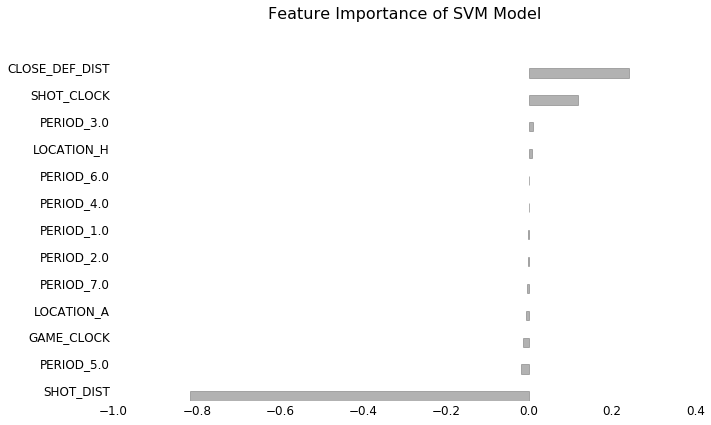

In [442]:
## Plot: Baseline, feature importance
SVM_rank = pd.DataFrame({'feature': features.tolist(),
                       'importance': svm.coef_[0]})

SVM_rank_sort = SVM_rank.sort_values(by='importance', ascending=True)

## plot feature importance
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(features))
bar_width = 0.35
opacity = 0.6

plt.barh(index, SVM_rank_sort['importance'], bar_width,
                 alpha=opacity,
                 color='grey',
                 edgecolor='grey')
 
#plt.xlabel('Score', fontsize=14)
#plt.ylabel('Models', fontsize=14)
plt.title('Feature Importance of SVM Model', fontsize=16)
plt.yticks(index + bar_width, SVM_rank_sort['feature'], fontsize=12, color='k')
plt.xticks(fontsize=12, color='k')
#plt.legend()
plt.grid(False)

# remove frame
ax.set_frame_on(False)
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
plt.tight_layout()
plt.show()

fig.savefig('SVM_feature_importance.png', bbox_inches='tight')

In [126]:
## guassian kernel, K-fold Cross Validation to Tune Regularization (C)
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
svm_cv_score = []

for c in c_values:
    cv_score = []
    model = SVC(kernel='rbf', C=c, random_state=0)
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    svm_cv_score.append(np.mean(cv_score))   

In [130]:
# when c_value = 100
svm_cv_score2

[0.60862923757202192]

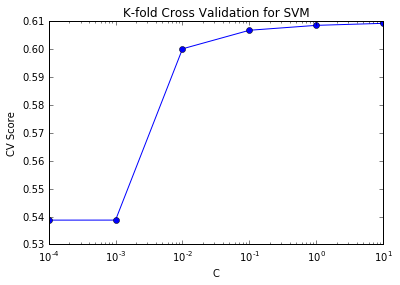

In [128]:
# visualization of k-fold CV
plt.semilogx(c_values, svm_cv_score,'bo-')
plt.xlabel("C")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for SVM")
plt.show()

In [342]:
## Baseline, linear kernel
svm = SVC(kernel='linear', random_state=0)
svm.fit(x_train, y_train)
print "Baseline score of SVM (linear kernel):", svm.score(x_test, y_test)

Baseline score of SVM (linear kernel): 0.583401006984


In [343]:
## linear kernel, K-fold Cross Validation to Tune Regularization (C)
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10]
svm_cv3_score = []

for c in c_values:
    cv_score = []
    model = SVC(kernel='linear', C=c, random_state=0)
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    svm_cv3_score.append(np.mean(cv_score))   

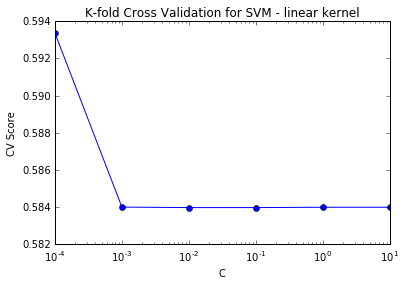

In [344]:
## linear kernel, K-fold Cross Validation to Tune Regularization (C)
# visualization of k-fold CV
plt.semilogx(c_values, svm_cv3_score,'bo-')
plt.xlabel("C")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for SVM - linear kernel")
plt.show()

In [345]:
svm_cv3_score[0]

0.59336281209522546

### 3.5 Random Forest

In [51]:
## Baseline
rf = RF(n_estimators=200, max_features='sqrt', random_state=0)
rf.fit(x_train, y_train)
print "Baseline score of Random Forest:", rf.score(x_test, y_test)

Baseline score of Random Forest: 0.576958475448


In [432]:
## Baseline, feature importance
print "Features:", final_df2_model.columns.values
print 'Feature Importance:', rf.feature_importances_

Features: ['GAME_CLOCK' 'SHOT_CLOCK' 'SHOT_DIST' 'CLOSE_DEF_DIST' 'LOCATION_A'
 'LOCATION_H' 'PERIOD_1.0' 'PERIOD_2.0' 'PERIOD_3.0' 'PERIOD_4.0'
 'PERIOD_5.0' 'PERIOD_6.0' 'PERIOD_7.0']
Feature Importance: [  2.64177751e-01   2.37726830e-01   2.63990365e-01   2.07033001e-01
   3.67292765e-03   3.65642614e-03   4.54454379e-03   4.88681647e-03
   4.85888321e-03   3.80323658e-03   1.05647137e-03   4.13492383e-04
   1.79255923e-04]


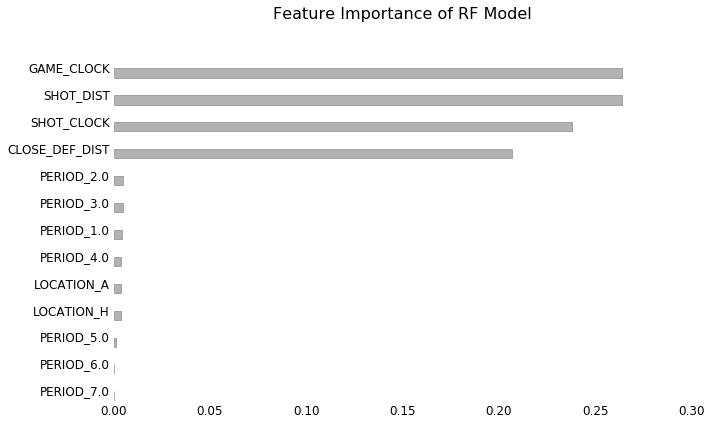

In [721]:
RF_rank = pd.DataFrame({'feature': features.tolist(),
                       'importance': rf.feature_importances_ })

RF_rank_sort = RF_rank.sort_values(by='importance', ascending=True)

## plot feature importance
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(features))
bar_width = 0.35
opacity = 0.6

plt.barh(index, RF_rank_sort['importance'], bar_width,
                 alpha=opacity,
                 color='grey',
                 edgecolor='grey')
 
#plt.xlabel('Score', fontsize=14)
#plt.ylabel('Models', fontsize=14)
plt.title('Feature Importance of RF Model', fontsize=16)
plt.yticks(index + bar_width, RF_rank_sort['feature'], fontsize=12, color='k')
plt.xticks(fontsize=12, color='k')
#plt.legend()
plt.grid(False)

# remove frame
ax.set_frame_on(False)
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
plt.tight_layout()
plt.show()

#fig.savefig('RF_feature_importance.png', bbox_inches='tight')

In [109]:
## K-fold Cross Validation to Tune Features (max_features)
feature_ratio = np.linspace(0.1,1,10)

rf_cv1_score = []

for i in feature_ratio:
    cv_score = []
    model = RF(n_estimators=200, max_features=i, random_state=0) 
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    rf_cv1_score.append(np.mean(cv_score)) 

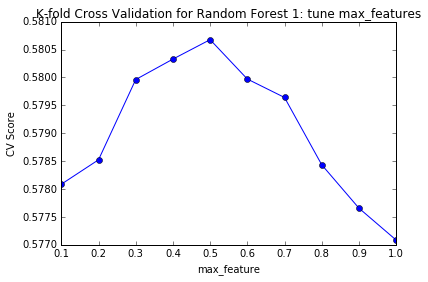

In [112]:
# visualization of k-fold CV
plt.plot(feature_ratio, rf_cv1_score,"bo-")
plt.xlabel("max_feature")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for Random Forest 1: tune max_features")
plt.show()

In [122]:
## K-fold Cross Validation to Tune Number of Trees (n_estimators)
tree_number = [100, 200, 300, 400, 500, 600]

rf_cv2_score = []

for n in tree_number:
    cv_score = []
    model = RF(n_estimators=n, max_features=0.5, random_state=0) 
    
    for train_index, test_index in KFold(len(x), n_folds=5, random_state=0):
        cv_x_train = x[train_index]
        cv_x_test = x[test_index]
        cv_y_train = y[train_index]
        cv_y_test = y[test_index]
        
        model.fit(cv_x_train, cv_y_train)
        score = model.score(cv_x_test, cv_y_test)
        cv_score.append(score)
        
    rf_cv2_score.append(np.mean(cv_score)) 

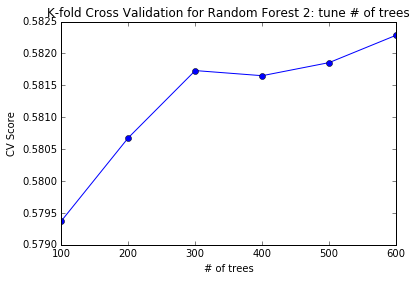

In [123]:
# visualization of k-fold CV
plt.plot(tree_number, rf_cv2_score,"bo-")
plt.xlabel("# of trees")
plt.ylabel("CV Score")
plt.title("K-fold Cross Validation for Random Forest 2: tune # of trees")
plt.show()

In [155]:
rf_cv2_score[-1]

0.58228594399035249

In [166]:
score_list = [0.5975583347, 0.6002858547, 0.5971793622, 'NaN', 0.4671376753, 'NaN',0.5540577121, 0.6033141275, 0.6099832169, 0.6092634776, 0.5769584754, 0.582285944]

In [182]:
model_list = ['LogReg','LDA','QDA','KNN','SVM','RanFor']

model_summary = pd.DataFrame({'Model':np.repeat(model_list,2),
                              'Tuned':['Base','Tuned']*6,
                            'CV Score':score_list})

In [183]:
model_summary

,CV Score,Model,Tuned
0,0.597558,LogReg,Base
1,0.600286,LogReg,Tuned
2,0.597179,LDA,Base
3,NaN,LDA,Tuned
4,0.467138,QDA,Base
5,NaN,QDA,Tuned
6,0.554058,KNN,Base
7,0.603314,KNN,Tuned
8,0.609983,SVM,Base
9,0.609263,SVM,Tuned


In [176]:
score_base = model_summary[model_summary['Tuned']=='Base']['CV Score']
score_tuned = model_summary[model_summary['Tuned']=='Tuned']['CV Score']

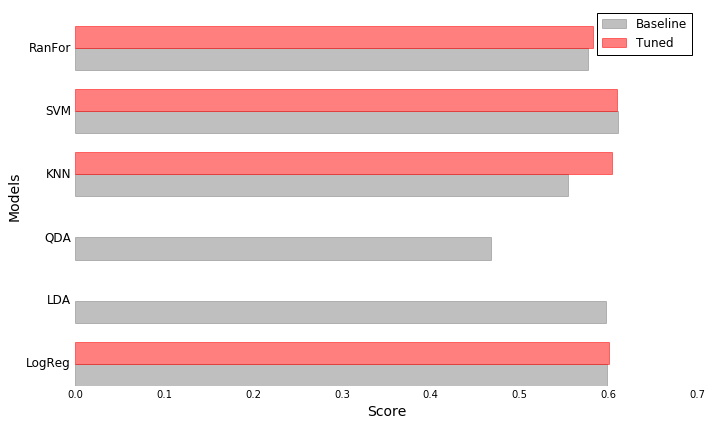

In [431]:
## plot model scores
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(len(model_list))
bar_width = 0.35
opacity = 0.5


 
rects1 = plt.barh(index, score_base, bar_width,
                 alpha=opacity,
                 color='grey',
                 edgecolor='grey',
                 label='Baseline')
 
rects2 = plt.barh(index + bar_width, score_tuned, bar_width,
                 alpha=opacity,
                 color='red',
                 edgecolor='red',
                 label='Tuned')
 
plt.xlabel('Score', fontsize=14)
plt.ylabel('Models', fontsize=14)
#plt.title('Performance of Classification Models to Predict [Shots Made]', fontsize=16)
plt.yticks(index + bar_width, model_list, fontsize=12)
plt.legend()
plt.grid(False)

# remove frame
ax.set_frame_on(False)
# remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
plt.tight_layout()
plt.show()

#fig.savefig('model_score.png', bbox_inches='tight')

## Part4 - Conditinoal Probability

To answer if Hot Hand Theory is true or not based on our data, we first replicated the work that was done by Gilovich, Vallone and Tsersky (1985), looking at the conditional probability of making a hit after hit(s) or miss(es). Assumining shots were chosen randomly, the probability of making a hit after a hit streak should be higher than the probability of making a hit after a miss streak, if Hot Hand Theory is true.
$$P(hit|hit(s)) \gt P(hit|miss(es))$$
We selected the top 5 player for analysis because they scored high, played in more games within the season, and shot more per game. This allows more series and longer series per player for the analysis.

In [748]:
top5_player_id = [2544, 201939, 201566, 2546, 202691]

### Making sure that the top five players make sense
print 'The top five players are:'
for player_id in top5_player_id:
    print '{}: {:s}'.format(player_id, name_id['player_name'][name_id['player_id'] == player_id].values[0])

The top five players are:
2544: lebron james
201939: stephen curry
201566: russell westbrook
2546: carmelo anthony
202691: klay thompson


In [766]:

# HTH
# Subset the data dataframe to contain only the top 5 players
print data.shape
data_top5 = data[(data['player_id'] == 2544) |
                 (data['player_id'] == 201939) |
                 (data['player_id'] == 201566) |
                 (data['player_id'] == 2546) |
                 (data['player_id'] == 202691)]
data_top5 = data_top5.reset_index(drop=True)
print data_top5.shape

# Create 3 columns to store the streat metrics
data_top5.loc[:, 'serie_id'] = np.nan # Each player has his set if serie_id starting from 1
data_top5.loc[:, 'MAKE_STREAK'] = np.nan # Number of cumulative shots made, 0 if miss
data_top5.loc[:, 'MISS_STREAK'] = np.nan # Number of cumulative shots missed, 0 if make
data_top5.loc[:, 'streak_metric'] = np.nan # MAKE_STREAK - MISS_STREAK
print data_top5.shape

# data_top5[:5] # Check

(111945, 16)
(4489, 16)
(4489, 20)


In [786]:
#### Fill in the streak metrics

# To keep track whether we are within the same game of the same player
p = data_top5.loc[0, 'player_id']
g = data_top5.loc[0, 'GAME_ID']

# Tracker
serie = 0

for index, row in data_top5.iterrows():
    if (p == row['player_id']) & (g == row['GAME_ID']):
        data_top5.loc[index, 'serie_id'] = serie
    elif (p == row['player_id']) & (g != row['GAME_ID']):
        g = row['GAME_ID']
        serie += 1
        data_top5.loc[index, 'serie_id'] = serie 
    elif (p != row['player_id']) & (g == row['GAME_ID']):
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie
    else:
        g = row['GAME_ID']
        p = row['player_id']
        serie = 0
        data_top5.loc[index, 'serie_id'] = serie

# Tracker
hit_count = 0
miss_count = 0
serie = data_top5.loc[0, 'serie_id']

for index, row in data_top5.iterrows():
    if serie == row['serie_id']:
        if row['SHOT_RESULT'] == 'made':
            hit_count += 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count += 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
    else:
        serie = row['serie_id']
        
        if row['SHOT_RESULT'] == 'made':
            hit_count = 1
            miss_count = 0
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count
        else:
            hit_count = 0
            miss_count = 1
            data_top5.loc[index, 'MAKE_STREAK'] = hit_count
            data_top5.loc[index, 'MISS_STREAK'] = miss_count
            data_top5.loc[index, 'streak_metric'] = hit_count - miss_count

# data_top5[:950] # Check

In [751]:
## Function:
## conditional_probability
    ## Input: p (player_id; only the top5 player id accepted)
## Calculate the field goal percentage of player with player_id

def conditional_probability(p):
    data_temp1 = data_top5[data_top5['player_id'] == p].reset_index(drop=True)

    hit_count = (data_temp1['MISS_STREAK'] == 0).sum()
    miss_count = (data_temp1['MAKE_STREAK'] == 0).sum()

#     print 'Player {} made {} shots in {} series'.format(p, data_temp1.shape[0], int(data_temp1['serie_id'].max()+1))

    # Tracker
    hit_hit1 = 0; miss_hit1 = 0; hit_miss1 = 0; miss_miss1 = 0
    hit_hit2 = 0; miss_hit2 = 0; hit_miss2 = 0; miss_miss2 = 0
    hit_hit3 = 0; miss_hit3 = 0; hit_miss3 = 0; miss_miss3 = 0
    serie = data_temp1.loc[0, 'serie_id']

    for serie in range(int(data_temp1['serie_id'].max() + 1)):
        df_temp = data_temp1[data_temp1['serie_id'] == serie].reset_index(drop=True)

        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] > 1):
                hit_hit1 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit1 += 1
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss1 += 1
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] < -1):
                miss_miss1 += 1
        
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] > 2):
                hit_hit2 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit2 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss2 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] < -2):
                miss_miss2 += 1
                
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] > 3):
                hit_hit3 += 1
            elif (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit3 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss3 += 1
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] < -3):
                miss_miss3 += 1

#     print 'P(hit|hit1) = {:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))
#     print 'P(hit|miss1) = {:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))
    
#     print 'P(hit|hit2) = {:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))
#     print 'P(hit|miss2) = {:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))

#     print 'P(hit|hit3) = {:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))
#     print 'P(hit|miss3) = {:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))

    d = {'player_name': [name_id['player_name'][name_id['player_id'] == p].values[0]],
         'P(hit|hit1)': ['{:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))],
         'P(hit|miss1)': ['{:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))],
         'P(hit|hit2)': ['{:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))],
         'P(hit|miss2)': ['{:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))],
         'P(hit|hit3)': ['{:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))],
         'P(hit|miss3)': ['{:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))],
         'P(hit)': ['{:.3f} ({})'.format(hit_count * 1. / (hit_count + miss_count), (hit_count + miss_count))]
        }

    df_temp2 = pd.DataFrame(d)
    return df_temp2

In [752]:
cols = ['player_name', 'P(hit|miss3)', 'P(hit|miss2)', 'P(hit|miss1)', 'P(hit)', 'P(hit|hit1)', 'P(hit|hit2)', 'P(hit|hit3)']
df_conditional = pd.DataFrame()

for p in top5_player_id:
    df_temp = conditional_probability(p)
    df_conditional = df_conditional.append(df_temp)
    
df_conditional[cols]

,player_name,P(hit|miss3),P(hit|miss2),P(hit|miss1),P(hit),P(hit|hit1),P(hit|hit2),P(hit|hit3)
0,lebron james,0.481 (81),0.554 (193),0.527 (440),0.497 (933),0.471 (442),0.445 (200),0.430 (86)
0,stephen curry,0.521 (73),0.548 (186),0.536 (440),0.495 (935),0.452 (438),0.434 (189),0.385 (78)
0,russell westbrook,0.418 (134),0.430 (251),0.459 (495),0.443 (937),0.421 (397),0.357 (157),0.333 (51)
0,carmelo anthony,0.576 (85),0.521 (190),0.471 (384),0.446 (737),0.410 (315),0.377 (122),0.422 (45)
0,klay thompson,0.495 (107),0.463 (227),0.470 (470),0.467 (947),0.469 (420),0.457 (186),0.418 (79)


For all top 5 players, the probabilities of making a hit after a hit streak (length 1-3) were lower than making a hit after a miss streak (length 1-3). Therefore, we observed no sign of hot hand for these top 5 players.

However, the connection between "hot hand" and a higher P(hit) conditioned on previous streak status is only true if each shot was chosen randomly from a pool of shots with varying difficulties. In real life, it is possible that as a player heats up, the defense gets tighter or the player starts making riskier shots as he feels more confident, both of which would mask the effect of "hot-hand". As a result, we consider modeling for the difficulty of each shot, and take the shot difficulty into account.

To account for shot difficulty, we used a strategy similar to what was previously described in Bocskocsky, Ezekowitz, and Stein (2014). Here, a linear regression model was trained using predictors including location, player, defender, shot distance, denfer distance and some time variables, to predict the probability of each shot being made.

The predicted P(hit) serves as a proxy for shot difficulty, which is used to calculate adjusted conditional probability. An analogy to how the adjusted probability is calculated is similar to correcting an unfair coin. For example, consider an unfair coin which shows head 30% of the time and tail 70% of the time. If for this coin, every time a head appears, I count it as 0.7 and if tail appears, 0.3, the adjusted expected value of getting a head or a tail would be around 0.5, as if the coin is fair.

In [753]:
# Because P(hit) does not have a linear relationship with SHOT_DIST
# We turn SHOT_DIST into 30 categorical groups of distances.
data['SHOT_DIST_BIN'] = pd.cut(data['SHOT_DIST'], 30)
print data.shape

# Build the dataframe needed for predicting P(hit)
# Encode categorical values with dummy variables
print 'Column names: ', data.columns.values

encoded_data = pd.DataFrame({})
categorical = ['LOCATION', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_id', 'SHOT_DIST_BIN']
continuous = ['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

for column in data.columns.values:
    if column in categorical:
        encoding = pd.get_dummies(data[column])
        encoded_data = pd.concat([encoded_data, encoding], axis = 1)
    elif column in continuous:
        encoded_data = pd.concat([encoded_data, data[column]], axis = 1)
        

print 'The shape of the encoded dataframe is', encoded_data.shape

# Turn the dataframe into a numpy array
# Predictor variables stored in X, and stadardized to X_std
X = encoded_data.as_matrix(columns=encoded_data.columns)
X_std = preprocessing.scale(X, axis=0)
print 'The shape of the predictor variables is', X_std.shape

# Response variable is stored in y
y = data['FGM']
print 'The shape of the response variable is', y.shape

(111945, 15)
Column names:  ['GAME_ID' 'LOCATION' 'SHOT_NUMBER' 'PERIOD' 'GAME_CLOCK' 'SHOT_CLOCK'
 'SHOT_DIST' 'SHOT_RESULT' 'CLOSEST_DEFENDER_PLAYER_ID' 'CLOSE_DEF_DIST'
 'FGM' 'PTS' 'player_id' 'shot_series_length' 'SHOT_DIST_BIN']
The shape of the encoded dataframe is (111945, 790)
The shape of the predictor variables is (111945, 790)
The shape of the response variable is (111945,)


In [756]:
# Linear regression
linreg = Lin_Reg()
linreg.fit(X_std, y)
print linreg.score(X_std, y)
y_predict = linreg.predict(X_std)

# Modify the predicted values to actual probability values
y_predict = np.array([0.999 if y_pred >= 1 else y_pred for y_pred in y_predict])
y_predict = np.array([0.001 if y_pred <= 0 else y_pred for y_pred in y_predict])
print 'The highest probability of P(hit) is:', y_predict.max()
print 'The lowest probability of P(hit) is:', y_predict.min()

0.0673473132743
The highest probability of P(hit) is: 0.999
The lowest probability of P(hit) is: 0.001


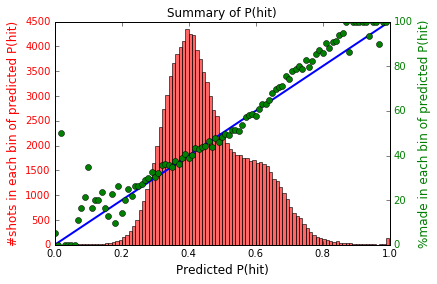

In [757]:
data['P'] = y_predict

p_range = np.arange(0, 100, 1)
p_average = np.array([])

for p in np.arange(0, 1, 0.01):
    p_average = np.append(p_average, data['FGM'][(data['P'] >= p) & (data['P'] < p + 0.01)].values.mean())

p_average = p_average * 100

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.set_title('Summary of P(hit)', fontsize = 12)

ax.hist(y_predict, bins = 100, color = 'r', alpha = 0.6)
ax.set_ylabel('#shots in each bin of predicted P(hit)', color='r', fontsize = 12)
ax.set_xlabel('Predicted P(hit)', fontsize = 12)
for tl in ax.get_yticklabels():
    tl.set_color('r')
    
ax2 = ax.twinx()
ax2.plot(np.arange(0, 1, 0.01), p_range, linewidth = 2)
ax2.plot(np.arange(0, 1, 0.01), p_average, 'o', c = 'g')
ax2.set_ylabel('%made in each bin of predicted P(hit)', color='g', fontsize = 12)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.show()

To visualize the predicted P(hit), we binned all shots whose values are within the same hundreth increment of the predicted P(hit). Then, the actual P(hit) was calculated based on the hit and miss statuses of all shots within the same bin. As the figure shows, the predicted P(hit) between 0.2 to 0.8 agrees really well with the acutal hit percentage. Since the majority of shots fall within this range, we believe the predicted P(hit) the mojority of our data is reliable.

In [782]:
# update data_top5 to contain column 'P'
data_top5['P'] = data[(data['player_id'] == 2544) |
                 (data['player_id'] == 201939) |
                 (data['player_id'] == 201566) |
                 (data['player_id'] == 2546) |
                 (data['player_id'] == 202691)]['P'].values

In [788]:
# Create data_temp1 for adjusted hit/miss values
data_temp1 = data_top5[data_top5['player_id'] == 2544].reset_index(drop=True)
hits = data_temp1['P'][data_temp1['MISS_STREAK'] == 0].values
misses = data_temp1['P'][data_temp1['MAKE_STREAK'] == 0].values
adjusted_hits = sum([1 / p for p in hits])
adjusted_misses = [1 / (1 - p) for p in misses]

In [775]:
## HTH
## Calculate the field goal percentage of player with player_id
def adjusted_conditional_probability(p):
    data_temp1 = data_top5[data_top5['player_id'] == p].reset_index(drop=True)

    hits = data_temp1['P'][data_temp1['MISS_STREAK'] == 0].values
    misses = data_temp1['P'][data_temp1['MAKE_STREAK'] == 0].values
    adjusted_hits = sum([1 / prob for prob in hits])
    adjusted_misses = sum([1 / (1 - prob) for prob in misses])
    
#     print 'Player {} made {} shots in {} series'.format(p, data_temp1.shape[0], int(data_temp1['serie_id'].max()+1))

    # Tracker
    hit_hit1 = 0; miss_hit1 = 0; hit_miss1 = 0; miss_miss1 = 0
    hit_hit2 = 0; miss_hit2 = 0; hit_miss2 = 0; miss_miss2 = 0
    hit_hit3 = 0; miss_hit3 = 0; hit_miss3 = 0; miss_miss3 = 0
    serie = data_temp1.loc[0, 'serie_id']

    for serie in np.arange(int(data_temp1['serie_id'].max() + 1)):
        df_temp = data_temp1[data_temp1['serie_id'] == serie].reset_index(drop=True)

        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] > 1):
                hit_hit1 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 0) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit1 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss1 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < 0) & (df_temp.loc[r+1, 'streak_metric'] < -1):
                miss_miss1 += (1 / (1 - df_temp.loc[r+1, 'P']))
        
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] > 2):
                hit_hit2 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 1) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit2 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss2 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < -1) & (df_temp.loc[r+1, 'streak_metric'] < -2):
                miss_miss2 += (1 / (1 - df_temp.loc[r+1, 'P']))
                
        for r in range(df_temp.shape[0] - 1):
            if (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] > 3):
                hit_hit3 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] > 2) & (df_temp.loc[r+1, 'streak_metric'] == -1):
                miss_hit3 += (1 / (1 - df_temp.loc[r+1, 'P']))
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] == 1):
                hit_miss3 += (1 / df_temp.loc[r+1, 'P'])
            elif (df_temp.loc[r, 'streak_metric'] < -2) & (df_temp.loc[r+1, 'streak_metric'] < -3):
                miss_miss3 += (1 / (1 - df_temp.loc[r+1, 'P']))

#     print 'P(hit|hit1) = {:.3f} ({})'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1), (hit_hit1 + miss_hit1))
#     print 'P(hit|miss1) = {:.3f} ({})'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1), (hit_miss1 + miss_miss1))
    
#     print 'P(hit|hit2) = {:.3f} ({})'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2), (hit_hit2 + miss_hit2))
#     print 'P(hit|miss2) = {:.3f} ({})'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2), (hit_miss2 + miss_miss2))

#     print 'P(hit|hit3) = {:.3f} ({})'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3), (hit_hit3 + miss_hit3))
#     print 'P(hit|miss3) = {:.3f} ({})'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3), (hit_miss3 + miss_miss3))

    d = {'player_name': [name_id['player_name'][name_id['player_id'] == p].values[0]],
         'P(hit|hit1)': ['{:.3f}'.format(hit_hit1 * 1./ (hit_hit1 + miss_hit1))],
         'P(hit|miss1)': ['{:.3f}'.format(hit_miss1 * 1./ (hit_miss1 + miss_miss1))],
         'P(hit|hit2)': ['{:.3f}'.format(hit_hit2 * 1./ (hit_hit2 + miss_hit2))],
         'P(hit|miss2)': ['{:.3f}'.format(hit_miss2 * 1./ (hit_miss2 + miss_miss2))],
         'P(hit|hit3)': ['{:.3f}'.format(hit_hit3 * 1./ (hit_hit3 + miss_hit3))],
         'P(hit|miss3)': ['{:.3f}'.format(hit_miss3 * 1./ (hit_miss3 + miss_miss3))],
         'P(hit)': ['{:.3f}'.format(adjusted_hits * 1. / (adjusted_hits + adjusted_misses))]
        }

    df_temp2 = pd.DataFrame(d)
    return df_temp2

In [789]:
cols = ['player_name', 'P(hit|miss3)', 'P(hit|miss2)', 'P(hit|miss1)', 'P(hit)', 
        'P(hit|hit1)', 'P(hit|hit2)', 'P(hit|hit3)']
df_conditional = pd.DataFrame()

for p in top5_player_id:
    df_temp = adjusted_conditional_probability(p)
    df_conditional = df_conditional.append(df_temp)
    
df_conditional[cols]

,player_name,P(hit|miss3),P(hit|miss2),P(hit|miss1),P(hit),P(hit|hit1),P(hit|hit2),P(hit|hit3)
0,lebron james,0.499,0.561,0.530,0.505,0.488,0.468,0.427
0,stephen curry,0.551,0.555,0.539,0.500,0.458,0.451,0.396
0,russell westbrook,0.472,0.486,0.506,0.500,0.489,0.423,0.410
0,carmelo anthony,0.612,0.566,0.511,0.502,0.480,0.452,0.503
0,klay thompson,0.533,0.496,0.502,0.504,0.512,0.507,0.470


After shot difficulty correction, as expected, P(hit) of most players are around 0.5.
However, most of the top 5 players still don't show hot hand based on these adjusted conditional probablities. Interesting, Klay Thompson, who recently scored 60 points within 29 minutes shows signs of hot hand when the probability is conditioned on one hit and two hits, in comparison with one miss and two misses.
For future direction, we would like to explore more players and also collect for more data on players like Klay Thompson, as it is possible that Hot Hand is more porminent on certain players than others. We also need to figure out if the 1% difference of the conditioned P(hit) for Thompson is significant or not.

## Part5 - Predictions on Long Streaks
We have the predictive model (basedline accurary is 0.6) that would predict whether the shot is made or missed sorely based on current shot condition, regardless of shot history.

We want to use this model to predict:

(1) the last shot of a long streak. For the last shot of a long make_streak, if the hot-hand theory is true, the shot would be more likely to be made then what the model predicts. Opposite for the miss_streak.

(2) the shot series of the whole streak. Similarly, for a long streak, the model would perform worse since the shots in the seires are more and more likely to be made/miss. 

### 5.1 Predictions vs Reality on the Last Shot of Streaks
by ZD

#### Fit Prediction Model on the Whole Data

In [677]:
## ZMD
#FGM in dataset takes value 1.0 if SHOT_RESULT is 'made' and 0.0 if SHOT_RESULT is 'missed'
top5_subset_data = final_df2[(final_df2.player_id == 2544) | (final_df2.player_id == 201939) |
                            (final_df2.player_id == 201566) | (final_df2.player_id == 2546) |
                            (final_df2.player_id == 202691)]

top5_subset_data['streak_metric'] = top5_subset_data['MAKE_STREAK'].values - top5_subset_data['MISS_STREAK'].values

top5_subset_data.head(4)

/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK,streak_metric
1152,21400010.0,H,1.0,1.0,585.0,2.8,18.7,made,2399.0,5.4,1.0,2.0,2546.0,13.0,1.0,0.0,1.0
1153,21400010.0,H,2.0,1.0,509.0,9.2,22.0,missed,2399.0,4.0,0.0,0.0,2546.0,13.0,0.0,1.0,-1.0
1154,21400010.0,H,3.0,1.0,439.0,5.3,6.1,missed,2399.0,1.7,0.0,0.0,2546.0,13.0,0.0,2.0,-2.0
1155,21400010.0,H,4.0,2.0,412.0,22.9,12.6,made,201959.0,4.4,1.0,2.0,2546.0,13.0,1.0,0.0,1.0


In [678]:
print 'max make_streak value in top5:', np.amax(top5_subset_data['MAKE_STREAK'].values)
print 'max miss_streak value in top5:', np.amax(top5_subset_data['MISS_STREAK'].values)

max make_streak value in top5: 13.0
max miss_streak value in top5: 9.0


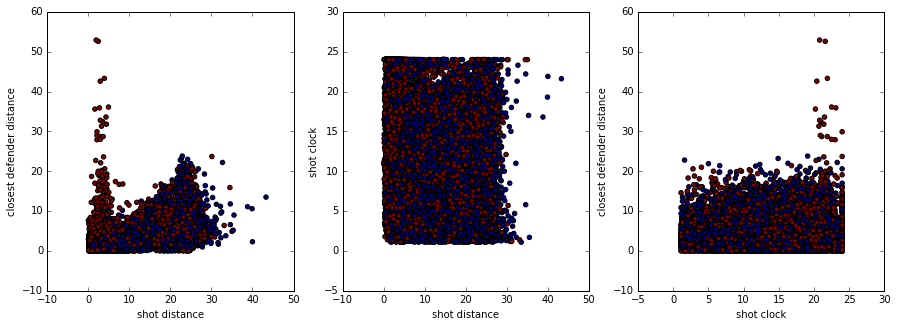

In [695]:
## ZMD 
# visualize relationship between predictors and shots made/missed

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(x_test['SHOT_DIST'], x_test['CLOSE_DEF_DIST'], c=y_test)
ax[0].set_xlabel('shot distance')
ax[0].set_ylabel('closest defender distance')

ax[1].scatter(x_test['SHOT_DIST'], x_test['SHOT_CLOCK'], c=y_test)
ax[1].set_xlabel('shot distance')
ax[1].set_ylabel('shot clock')

ax[2].scatter(x_test['SHOT_CLOCK'], x_test['CLOSE_DEF_DIST'], c=y_test)
ax[2].set_xlabel('shot clock')
ax[2].set_ylabel('closest defender distance')

plt.show()

#### Null Model

In [699]:
final_df2.head(3)

fgm = final_df2['FGM'].values
null_shots = []
for i in np.arange(len(fgm)):
    x = np.random.rand()
    if (x < .5):
        null_shots.append(0.0)
    else:
        null_shots.append(1.0)

print 'proportion of shots made:', sum(fgm)/len(fgm)*1.0 # proportion of shots that are made in dataset

score = 0

for i in range(len(fgm)):
    if fgm[i] == null_shots[i]:
        score += 1

print 'regression score of null model to predict shots:', score*1.0/len(fgm)

proportion of shots made: 0.461271159945
regression score of null model to predict shots: 0.502532493635


#### Fit LogReg to Full Data

In [700]:
## ZMD

response = final_df2['FGM'].values
predictors = final_df2[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.5)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score:', lr.score(x_test, y_test)

classification score: 0.599789184071


In [701]:
## ZMD

#lr.fit model to entire dataset before running this
# examine the max make_streak value (make_streak = 13) - game_ID=21400651, player_Id = 202691

subset = top5_subset_data[(top5_subset_data.GAME_ID == 21400651) & (top5_subset_data.player_id == 202691)]
subset.shape
lr.score(subset[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], subset['FGM'])

0.52000000000000002

#### Analysis of Streak Likelihood based on LR model

In [702]:
print 'max make_streak value:', np.amax(final_df2['MAKE_STREAK'].values)
print 'max miss_streak value:', np.amax(final_df2['MISS_STREAK'].values)

max make_streak value: 14.0
max miss_streak value: 13.0


#### (1) make streaks

In [703]:
## ZMD
#lr.fit model to entire dataset before running this

# examine the max make_streak value (make_streak = 14)
analyzed_streaks = []
lr_scores = []

subset = final_df2[final_df2['MAKE_STREAK'] == 14]

gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)


evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

make14 = []
make14.append(lr_scores[0])

In [704]:
subset = final_df2[final_df2['MAKE_STREAK'] == 13]

gameid = subset.get_value(1,0, True)
playerid = subset.get_value(1,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,2]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

make13 = []
make13.append(lr_scores[1])

In [705]:
#subset = final_df2[final_df2['MAKE_STREAK'] == 12] no new streaks

subset = final_df2[final_df2['MAKE_STREAK'] == 11]

gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,12,13,14]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

make12 = []
make12.append(lr_scores[2])

In [706]:
subset = final_df2[final_df2['MAKE_STREAK'] == 10]
subset = subset.drop(subset.index[[2,4,5]])
#subset.head(5)

make11 = []

gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))
make11.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(1,0, True)
playerid = subset.get_value(1,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))
make11.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)]
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,2,3,4]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))
make11.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

In [707]:
#print lr_scores
#print analyzed_streaks

print make14, make13, make12, make11

[0.7857142857142857] [0.30769230769230771] [0.45454545454545453] [0.5, 0.40000000000000002, 0.5]


In [708]:
#convert to pd to allow looping over values
analyzed_pd = pd.DataFrame(analyzed_streaks)
analyzed_pd.columns=('GAME_ID', 'player_id')

subset = final_df2[final_df2['MAKE_STREAK'] == 9] # no make_streak = 10 which aren't already analyzed
print subset.shape
indices=[]
for i in range(subset.shape[0]):
    gameid = subset.get_value(i,0, True)
    playerid = subset.get_value(i,12, True)

    if (gameid in analyzed_pd['GAME_ID'].values):
        index = np.where(analyzed_pd['GAME_ID'].values == gameid)
        #if np.any(playerid == analyzed_pd.get_value(index, 1, True)):
        indices.append(i)
subset = subset.drop(subset.index[[indices]])

print subset.shape

(18, 16)
(12, 16)


In [709]:
#loop over subset of remaining streaks to examine data
for i in range(12):
    gameid = subset.get_value(i,0, True)
    playerid = subset.get_value(i,12, True)

    evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
    print evaluate_streak.head(5)

         GAME_ID LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK  SHOT_CLOCK  \
3566  21400031.0        H          2.0     1.0       380.0        15.1   
3567  21400031.0        H          3.0     1.0       311.0         1.6   
3568  21400031.0        H          4.0     2.0       382.0        13.5   
3569  21400031.0        H          5.0     2.0       334.0         7.4   
3570  21400031.0        H          6.0     2.0       215.0        22.3   

      SHOT_DIST SHOT_RESULT  CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  FGM  \
3566        4.4        made                    203953.0             1.7  1.0   
3567       20.7        made                      2585.0             9.4  1.0   
3568        3.8        made                    202336.0             2.1  1.0   
3569       19.0        made                    202336.0             4.8  1.0   
3570       16.3        made                      2585.0             5.5  1.0   

      PTS  player_id  shot_series_length  MAKE_STREAK  MISS_STREAK  
3566 

In [710]:
gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(1,0, True)
playerid = subset.get_value(1,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(3,0, True)
playerid = subset.get_value(3,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,2,12]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(4,0, True)
playerid = subset.get_value(4,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[9]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(5,0, True)
playerid = subset.get_value(5,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(6,0, True)
playerid = subset.get_value(6,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(7,0, True)
playerid = subset.get_value(7,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(8,0, True)
playerid = subset.get_value(8,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(9,0, True)
playerid = subset.get_value(9,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(10,0, True)
playerid = subset.get_value(10,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[9,10,11,12,13,14,15,16]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(11,0, True)
playerid = subset.get_value(11,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MAKE_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,2,3,4]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

make9 = lr_scores[6:]

In [711]:
print make9

[0.66666666666666663, 0.77777777777777779, 0.66666666666666663, 0.66666666666666663, 0.44444444444444442, 0.88888888888888884, 0.77777777777777779, 0.55555555555555558, 0.55555555555555558, 0.66666666666666663, 0.22222222222222221, 0.1111111111111111]


#### (2)miss streaks

In [712]:
analyzed_streaks = []
lr_scores = []

subset = final_df2[final_df2['MISS_STREAK'] == 13]

gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player

evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,15,16]]) # drop non-series shots by visual inspection

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

miss13 = []
miss13.append(lr_scores[0])

In [713]:
subset = final_df2[final_df2['MISS_STREAK'] == 12]

gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[13,14]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


miss12 = lr_scores[1:]

In [714]:
subset = final_df2[final_df2['MISS_STREAK'] == 11]
subset = subset.drop(subset.index[[4,6,9]])


gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(1,0, True)
playerid = subset.get_value(1,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(3,0, True)
playerid = subset.get_value(3,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(4,0, True)
playerid = subset.get_value(4,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(5,0, True)
playerid = subset.get_value(5,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[11]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(6,0, True)
playerid = subset.get_value(6,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

miss11 = lr_scores[3:]

In [715]:
#convert to pd to allow looping over values
analyzed_pd = pd.DataFrame(analyzed_streaks)
analyzed_pd.columns=('GAME_ID', 'player_id')

subset = final_df2[final_df2['MISS_STREAK'] == 10]

indices=[]
for i in range(subset.shape[0]):
    gameid = subset.get_value(i,0, True)
    playerid = subset.get_value(i,12, True)

    if (gameid in analyzed_pd['GAME_ID'].values):
        index = np.where(analyzed_pd['GAME_ID'].values == gameid)
        #if np.any(playerid == analyzed_pd.get_value(index, 1, True)):
        indices.append(i)
subset = subset.drop(subset.index[[indices]])

subset.shape

(14, 16)

In [716]:
#loop over subset of remaining streaks to examine data
for i in range(10):
    gameid = subset.get_value(i,0, True)
    playerid = subset.get_value(i,12, True)

    evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
    print evaluate_streak.head(5)

         GAME_ID LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK  SHOT_CLOCK  \
3271  21400028.0        A          1.0     1.0       504.0        14.2   
3272  21400028.0        A          2.0     1.0       456.0        17.5   
3273  21400028.0        A          3.0     1.0       221.0        10.4   
3274  21400028.0        A          4.0     2.0       281.0        16.7   
3275  21400028.0        A          5.0     2.0       180.0         9.1   

      SHOT_DIST SHOT_RESULT  CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  FGM  \
3271       17.3      missed                    202689.0             4.3  0.0   
3272       21.1      missed                    202689.0             4.4  0.0   
3273        3.3      missed                    203469.0             1.4  0.0   
3274        8.8      missed                    203469.0             3.4  0.0   
3275        1.8      missed                      2744.0             0.2  0.0   

      PTS  player_id  shot_series_length  MAKE_STREAK  MISS_STREAK  
3271 

In [717]:
gameid = subset.get_value(0,0, True)
playerid = subset.get_value(0,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[10]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(1,0, True)
playerid = subset.get_value(1,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,11,12,13,14,15]])

analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(2,0, True)
playerid = subset.get_value(2,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(3,0, True)
playerid = subset.get_value(3,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(4,0, True)
playerid = subset.get_value(4,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[10,11,12]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(5,0, True)
playerid = subset.get_value(5,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(6,0, True)
playerid = subset.get_value(6,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[10,11]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

gameid = subset.get_value(7,0, True)
playerid = subset.get_value(7,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,12]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(8,0, True)
playerid = subset.get_value(8,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0,1,2,3]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))


gameid = subset.get_value(9,0, True)
playerid = subset.get_value(9,12, True)

evaluate_streak = final_df2[(final_df2['GAME_ID'] == gameid) & (final_df2['player_id'] == playerid) & 
                            (final_df2['MISS_STREAK'] != 0)] # drop any shots made by player
evaluate_streak = evaluate_streak.drop(evaluate_streak.index[[0]])
analyzed_streaks.append([gameid, playerid])
lr_scores.append(lr.score(evaluate_streak[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']], evaluate_streak['FGM']))

miss10 = lr_scores[10:]

In [718]:
#print analyzed_streaks
#print lr_scores

print miss13, miss12, miss11, miss10

[0.46153846153846156] [0.76923076923076927, 0.58333333333333337] [0.36363636363636365, 0.72727272727272729, 0.81818181818181823, 0.63636363636363635, 0.83333333333333337, 0.81818181818181823, 0.63636363636363635] [0.59999999999999998, 0.5, 0.69999999999999996, 0.40000000000000002, 0.90000000000000002, 0.80000000000000004, 0.5, 0.90000000000000002, 0.59999999999999998, 0.69999999999999996]


#### Visualizing Results

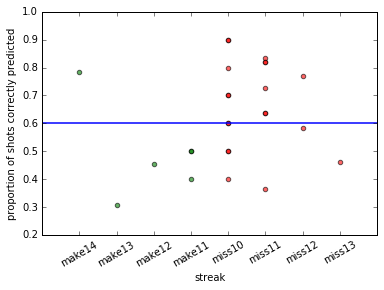

In [719]:
plt.axhline(y=0.601, linewidth=1.5, color = 'b') # correctly predicted shots from full dataset

y = [make14, make13, make12, make11]
x = [1,2,3,4]

for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye, c='g', alpha=0.6)
    
y = [miss10, miss11, miss12, miss13]
x = [5, 6,7,8]
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye, c='r', alpha=0.6)
    
    
plt.xticks([1,2,3,4,5,6,7,8])
plt.axes().set_xticklabels(['make14', 'make13', 'make12', 'make11', 
                            'miss10', 'miss11', 'miss12', 'miss13'], rotation=30)

plt.ylabel('proportion of shots correctly predicted')
plt.xlabel('streak')

plt.show()

We can see that the model did perform poorly (worse then baseline) in make12, make13 and miss13. This might be a weak hint of the hot-hand theory. Although the variance is huge, and more data may be needed to confirm the trend.

#### Home vs Away Game

In [720]:
## ZMD
# compare prediction by logreg of whether or not shot is made for home vs away games

### home
response = final_df2[final_df2.LOCATION == 'H']['FGM']
predictors = final_df2[final_df2.LOCATION == 'H'][['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score for home games:', lr.score(x_test, y_test)

### away
response = final_df2[final_df2.LOCATION == 'A']['FGM']
predictors = final_df2[final_df2.LOCATION == 'A'][['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'classification score for away games:', lr.score(x_test, y_test)

classification score for home games: 0.598266991606
classification score for away games: 0.600768481437


Using basic predictors shot_clock, shot_dist, and close_def_dist, which are decent representative markers of shot difficulty, logistic regression correctly predicts whether a shot is made or missed roughly 60% of the time. There is no significant difference between prediction of shots made at home vs away games. Looking at the most successful make_streak of 13 shots made in a row by a top5 player (selected by most points per game ie PPG), the model trained to the entire dataaset by cross validation only results in a score of 0.48, meaning that based on the broader training set for this particular streak more that half the shots that were made were expected to be missed by the trained model.

### 5.2 Prediction vs Reality on the Whole Streak

Subsetting data by Streak and then training subsetted data to predict fg%. Then we compared fg% for each streak to see if it increased as streak increased.

by Bailey

In [741]:
predictors = final_df2[['SHOT_CLOCK', 'CLOSE_DEF_DIST', 'SHOT_DIST']]
response = final_df2['FGM']
x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

In [742]:
fgpct = []
for i in range(10):
    data_subset = final_df2[final_df2['MAKE_STREAK'] == i]
    subset_predict = data_subset[['SHOT_CLOCK', 'CLOSE_DEF_DIST', 'SHOT_DIST']]
    lr = LogReg()
    lr.fit(x_train, y_train)
    lr_predict = lr.predict(subset_predict)
    fgpct.append(np.sum(lr_predict)/len(lr_predict))
fgpct

[0.30264641506931089,
 0.49747843397478436,
 0.47033697199810159,
 0.47396226415094339,
 0.46813388353966073,
 0.48780487804878048,
 0.51290322580645165,
 0.53333333333333333,
 0.52941176470588236,
 0.5]

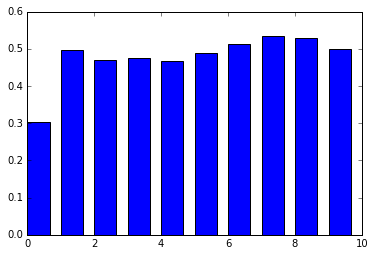

In [743]:
y = fgpct
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")
plt.show()

#### Compare Predicion Score for Good and Poor Players

In [746]:
# Good Players, 'PTS' > 10
playersabove10 = player_ppg_top[player_ppg_top['PTS'] > 10]

dataabove10 = final_df2[(final_df2.player_id.isin(playersabove10['player_id']))]
response = dataabove10['FGM']
predictors = dataabove10[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'score for players above 10ppg:', lr.score(x_test, y_test)

score for players above 10ppg: 0.605254798748


In [747]:
# Poor Players, 'PTS' < 10
playersbelow10 = player_ppg_top[player_ppg_top['PTS'] < 10]

databelow10 = final_df2[(final_df2.player_id.isin(playersbelow10['player_id']))]
response = databelow10['FGM']
predictors = databelow10[['SHOT_CLOCK', 'SHOT_DIST', 'CLOSE_DEF_DIST']]

x_train, x_test, y_train, y_test = sk_split(predictors, response, test_size=0.33)

lr = LogReg()
lr.fit(x_train, y_train)
print 'score for players below 10ppg:', lr.score(x_test, y_test)

score for players below 10ppg: 0.599297012302


We can see that: compare players who scored a lot more to palyers who score less, the prediction model didn't preform too differently, suggesting that players who scored more are not more likely to score later.  

## Conclusion

- We didn't see obvious hot-hand in both direct conditional probability, and conditional probability adjusted for shot difficulty.
- Analysis of long shot_streak show weak hint of hot-hand, though more data are needed to confirm.
- Top players who scored more in our data set don't particularly have hot-hand.
- Games played at home or away wouldn't induce or suppress hot-hand.

## Future Direction
- More data (of other seasons, players) to provide more long streaks for analysis.
- More detailed features of the shot condition (eg. the exact position of the shot instead of shot_distance) to build better classification model.
- Data of specific palyers who tend to be hot-hand or have been hot-hand in certain games.